# Ejercicio de Forecasting 
Comenzamos llamando los paquetes que *necesitamos*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from warnings import filterwarnings

from pylab import rcParams
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
# Preparamos el entorno para las visualizaciones
sns.set()

In [3]:
filterwarnings('ignore')

# Carga de datos y EDA
Cargamos los datos y realizamos el análisis exploratorio para comprenderlos mejor.

In [4]:
df_ventas = pd.read_csv("data_prueba_Forecasting.csv", on_bad_lines='skip')
# Pasamos las fechas a Datetime
df_ventas['id_fec_diaria'] = pd.to_datetime(df_ventas['id_fec_diaria'],  errors='coerce')
# Eliminamos columnas que no aportan información
df_ventas = df_ventas.drop(['Unnamed: 0', 'Tienda'], axis=1)
df_ventas.head()

,Formato,Subformato,Producto,id_fec_diaria,Venta,Precio,Venta_aa,Precio_aa
0,Super,Basico,369772,2021-08-01,7.0,17.168571,5.0,21.063200
1,Super,Basico,369772,2021-08-02,6.0,17.141667,3.0,21.388667
2,Super,Basico,369772,2021-08-03,5.0,17.136000,5.0,21.376199
3,Super,Basico,369772,2021-08-04,4.0,16.995000,3.0,21.360367
4,Super,Basico,369772,2021-08-05,1.0,17.240000,1.0,21.397100


Obtenemos información de los datos y eliminamos los valores nulos

In [5]:
df_ventas.info()
df_ventas = df_ventas.dropna();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426377 entries, 0 to 426376
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Formato        426377 non-null  object        
 1   Subformato     426377 non-null  object        
 2   Producto       426377 non-null  int64         
 3   id_fec_diaria  426377 non-null  datetime64[ns]
 4   Venta          426377 non-null  float64       
 5   Precio         426377 non-null  float64       
 6   Venta_aa       426377 non-null  float64       
 7   Precio_aa      426377 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 26.0+ MB


Obtenemos un resumen de nuetro data set.

In [6]:
df_ventas.describe()

,Producto,Venta,Precio,Venta_aa,Precio_aa
count,4.263770e+05,426377.000000,426377.000000,426377.000000,426377.000000
mean,5.120868e+06,68.534217,61.782508,73.905263,58.161344
std,4.911189e+06,319.971154,70.248355,348.099302,66.369279
min,1.160000e+02,0.076000,0.870000,0.084000,0.008500
25%,1.035460e+06,4.000000,23.902857,4.000000,22.561006
50%,2.101039e+06,11.000000,40.270741,12.000000,38.382699
75%,1.120037e+07,38.000000,74.882001,41.000000,68.401846
max,1.153318e+07,41883.469971,1650.859985,46097.408234,1591.921753


In [7]:
df_ventas.shape

(426377, 8)

Identificamos que hay 6 tipo diferentes de tienda.

In [8]:
df_ventas.groupby(df_ventas['Formato'])['Subformato'].unique()

Formato
Hiper    [Plus, Basico, Intermedio]
Super    [Basico, Intermedio, Plus]
Name: Subformato, dtype: object

Separamos en listas las variables categóricas de las numéricas.

In [9]:
categorical = ['Formato', 'Subformato', 'Producto', 'id_fec_diaria']
numerical = ['Precio', 'Venta_aa', 'Precio_aa']

# Ventas promedio por día
Nuestra primer aproximación es con el promedio de las ventas por cada tienda-producto para cada día. Transformamos el data set para mostrar el promedio de ventas para cada día.


In [10]:
venta_promedio = df_ventas.groupby('id_fec_diaria').mean()['Venta']
venta_promedio.head()

id_fec_diaria
2021-08-01    87.526756
2021-08-02    81.023666
2021-08-03    94.857021
2021-08-04    79.690219
2021-08-05    50.588815
Name: Venta, dtype: float64

Separamos en datos de entrenamiento y prueba, usaremos los últimos diescisiete días como set de pruebas (2021-10-15 a 2021-10-31).

In [11]:
train = venta_promedio[:-17]
test = venta_promedio[-17:]

Graficamos la serie temporal separada por los datos de prueba y entrenamiento.

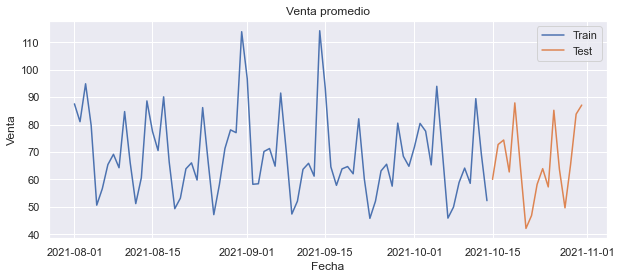

In [12]:
plt.figure(figsize=(10,4))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.ylabel('Venta')
plt.xlabel('Fecha')
plt.title('Venta promedio')
plt.legend()
plt.show()

## Descomposición de la serie de tiempo
Despupes de observar la serie, procedemos a descomponerla en sus partes, en busqueda de los valores de level, trend, seasonality y residual.
Usaremos la descripción de un modelo multiplicativo:

$$y(t) = Level*Trend*Seasoanlity*Noise$$

ya que se observa que la serie es no-lineal, esto debido a que el valor de trend es una curva, el valor de seasonality no es constante, lo cual lleva a un cambio global no constante sobre el tiempo. 


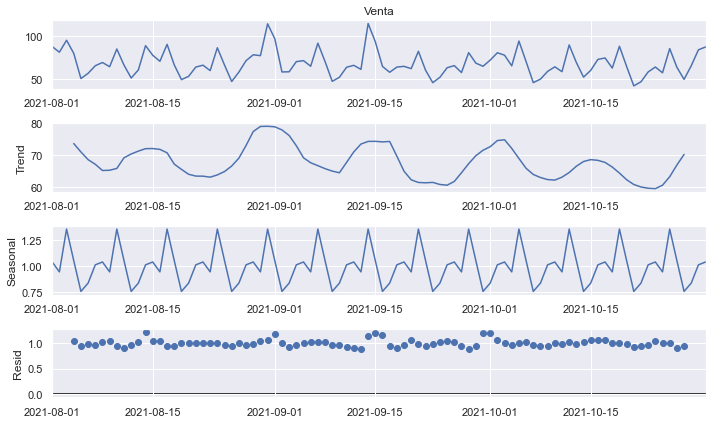

In [13]:
rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(venta_promedio, model='multiplicative')
decomposition_plot = decomposition.plot()

Continuamos el análisis de esta serie de tiempo, la componente de Noise. Se dice que hay white noise cuando si las mediciones estan distribuidas identicamente conmedia cero y sí son independientes. Sí hay white noise no podriamos predecir dicha componente y el modelo tendría errores del orden del white noise. En las siguientes gráficas podemos observar que no hay white noise.

Text(0.5, 1.0, 'Media por tiempo')

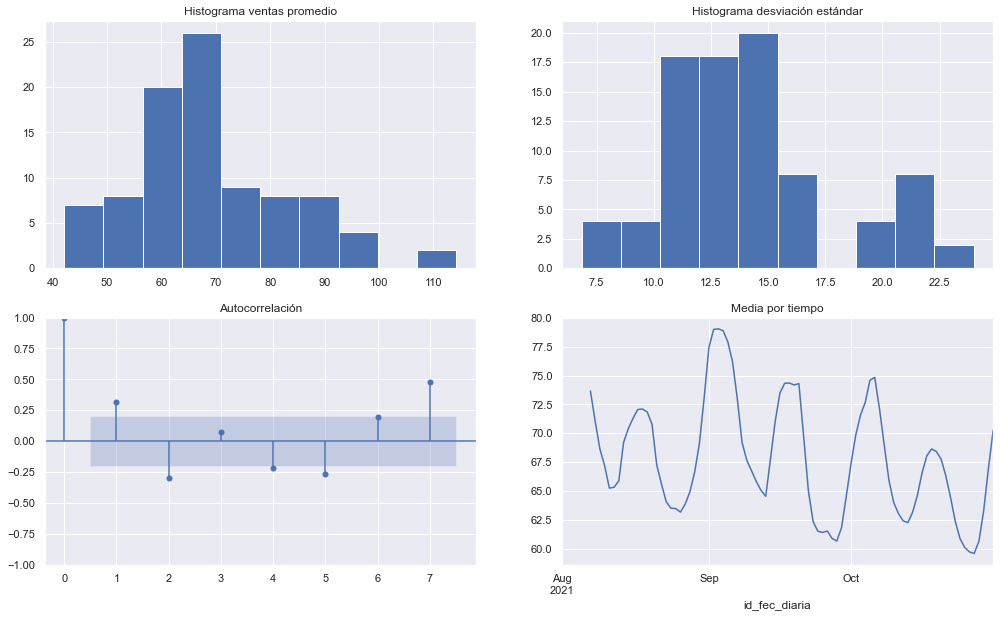

In [14]:
fig = plt.figure(figsize=(17, 10))
layout = (2,2)
hist_ax = plt.subplot2grid(layout, (0,0))
ac_ax = plt.subplot2grid(layout, (1,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,1))
venta_promedio.hist(ax=hist_ax)
hist_ax.set_title("Histograma ventas promedio")
plot_pacf(venta_promedio, lags = 7, ax = ac_ax)
ac_ax.set_title("Autocorrelación")
mm = venta_promedio.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Histograma desviación estándar")
mm = venta_promedio.rolling(7).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Media por tiempo")

## Estacionariedad y autocorrelación
La estacionariedad es probablemente la característica más importante de las series de tiempo. Se dice que una serie es estacionaria cuando su media y varianza sobre el tiempo son mayormente constantes. La mayoría de los modelos solamente funcionan con datos estacionarios. No todas las series son estacionarias pero se pueden transformar en diferentes maneras.
En la siguiente gráfica observamos el comportamiento de la media y la desviación estándar móviles.

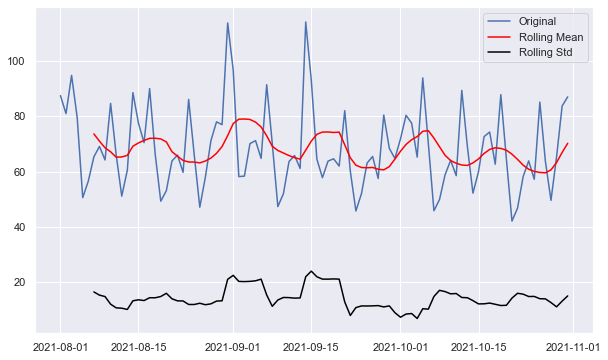

In [15]:
# Ventana de 7 días
rollstd = venta_promedio.rolling(7).std()
rollmean = venta_promedio.rolling(7).mean()

plt.figure(figsize=(10,6))
plt.plot(venta_promedio, label='Original')
plt.plot(rollmean, color='red', label='Rolling Mean')
plt.plot(rollstd, color='black', label='Rolling Std' )
plt.legend(loc='best')


## Detección de anomalías
Detectemos anomalías en esta serie, utilizando quantiles, que son partes de los datos en cierto porcentaje general de ellos. En la siguiente gráfica identificamos estos puntos particulares. 

id_fec_diaria
2021-08-31    113.842382
2021-09-14    114.197202
Name: Venta, dtype: float64


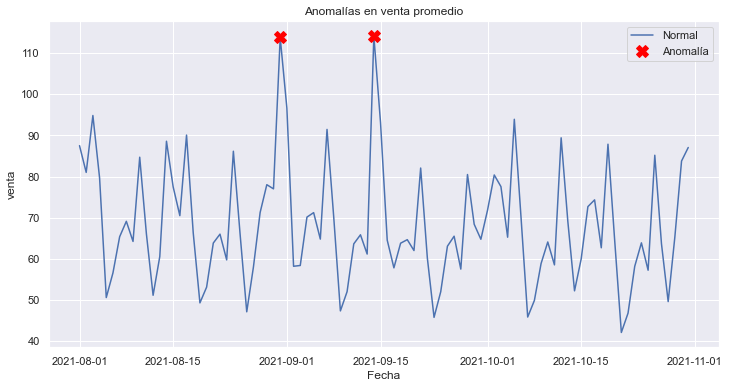

In [16]:
q1_pc1, q3_pc1 = venta_promedio.quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
anomaly = ((venta_promedio>upper_pc1) | (venta_promedio<lower_pc1)).astype('int')
anomal = venta_promedio[anomaly == 1]
plt.figure(figsize=(12,6))
plt.plot(venta_promedio, label='Normal')
plt.plot(anomal, linestyle='none', marker='X', color='red',
markersize=12, label='Anomalía')
plt.xlabel('Fecha')
plt.ylabel('venta')
plt.title("Anomalías en venta promedio")
plt.legend(loc='best')
print(anomal)


Se muestran los valores con sus respectivos timestamps de dichas anomalías, una hipotesis es que este aumento de ventas es debido a para Agosto, el regreso a clases, y para Septiembre el aumento es en torno a la celebreación de la Independencia Mexicana.

## Pronóstico
LLegamos a la parte del pronóstico utilizando esta serie de tiempo, aquí se utilizan los siguientes modelos.

### SARIMAX
Utilizamos esta técnica estadística para hacer nuestro primer pronóstico.


In [17]:
data = venta_promedio

Entrenamos el modelo y mostramos algunas de sus características. 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0920     25.983     -0.004      0.997     -51.017      50.833
ma.L2         -0.2225     23.482     -0.009      0.992     -46.246      45.801
ma.L3         -0.3652     17.761     -0.021      0.984     -35.175      34.445
ma.L4         -0.2610      8.356     -0.031      0.975     -16.639      16.117
ma.L5         -0.0380      1.588     -0.024      0.981      -3.151       3.075
ma.L6         -0.0200      0.684     -0.029      0.977      -1.360       1.320
ma.S.L7       -0.8655      0.145     -5.950      0.000      -1.151      -0.580
sigma2        38.3911    995.997      0.039      0.969   -1913.727    1990.509


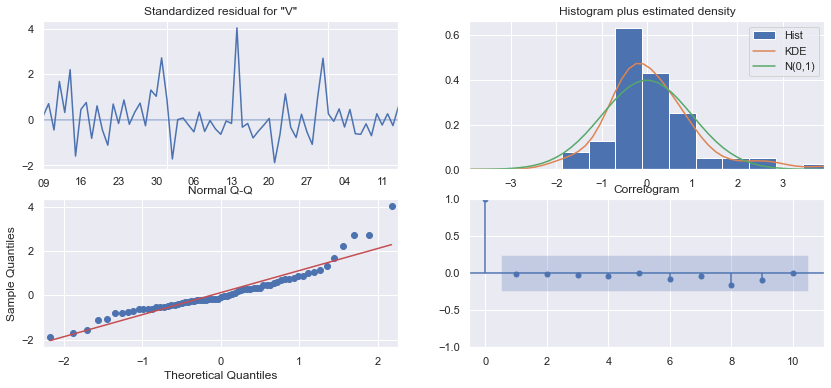

In [18]:
model=sm.tsa.statespace.SARIMAX(
    data[:-17],
    order=(0, 1, 6),
    seasonal_order=(0,1,1,7))

results=model.fit()

print(results.summary().tables[1])
results_plot = results.plot_diagnostics(figsize=(14, 6))


Realizamos la predicción, graficamos tanto los valores de la serie original como la predicción para hacer la validación del modelo, y obtenemos el mean squared log error.

Mean squared log error:  0.01575454484100578


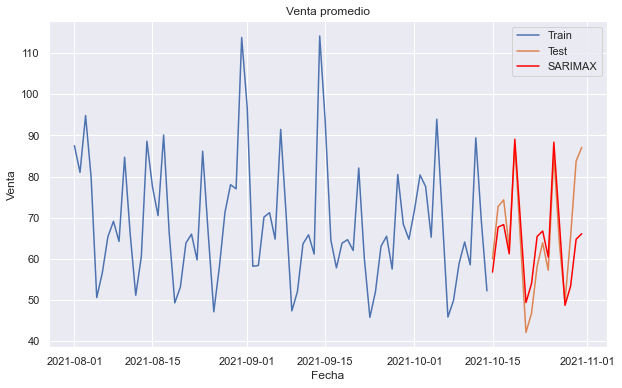

In [19]:
y_pred = results.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1], dynamic=False)
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.figure(figsize=(10,6))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(y_pred_out, color='Red', label = 'SARIMAX')
plt.ylabel('Venta')
plt.xlabel('Fecha')
plt.title('Venta promedio')
plt.legend()

msle0 = mean_squared_log_error(test.values, y_pred_df['Predictions'].values)
print("Mean squared log error: ", msle0)

### Transformacion de datos
Para los siguientes modelos hay que tener ingresar los datos de otra manera, realizamos ingeniería de características, creando nuevas características a partir de los datos de los timestamps de la serie.

In [20]:
df_new = pd.DataFrame({'Date':venta_promedio.keys(), 'Venta':venta_promedio.values})
df_new.set_index('Date');

In [21]:
df = pd.DataFrame({})
df['date'] = pd.to_datetime(venta_promedio.index)
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['sin_day'] = np.sin(df['dayofyear'])
df['cos_day'] = np.cos(df['dayofyear'])
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
X = df.drop(['date'],axis=1)
y = df_new['Venta'];


Procedemos a separar el set transformado y lo escalamos para que no se obtengan sesgoz por el peso de ciertos valores muy grandes.

In [22]:
X_train_df, X_test_df, y_train, y_test = X[:-17], X[-17:], y[:-17], y[-17:]
scaler = StandardScaler()

scaler.fit(X_train_df)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

## XGBoost
Utilizamos el XGBRegressor para el sigueinte pronóstico.

In [23]:
# XGBoost

reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train, verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Obtenemos la predicción y realizamos la validación del modelo, al igual utilizamos la métrica de MSLE para comparar con los demas modelos.

0.00856847162219199


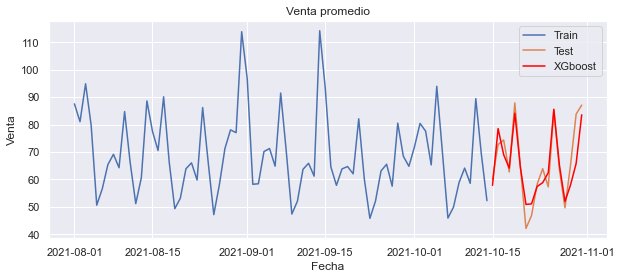

In [24]:
yhat = reg.predict(X_test)
plt.figure(figsize=(10,4))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(venta_promedio.index[-17:], yhat,color='red',label='XGboost')
plt.ylabel('Venta')
plt.xlabel('Fecha')
plt.title('Venta promedio')
plt.legend()

msle1 = mean_squared_log_error(y_test, yhat)
print(msle1)

## KNeighbors
Utilizamos también el modelo de KNeighborsRegressor para realizar el pronóstico, validamos y obtenemos el MSLE.

0.02969708354915294


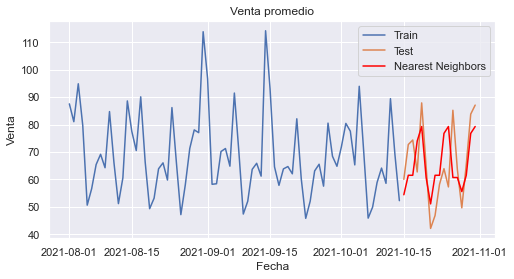

In [25]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
plt.figure(figsize=(8, 4))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(df_new['Date'][-17:], yhat, color='red',label='Nearest Neighbors')
plt.ylabel('Venta')
plt.xlabel('Fecha')
plt.title('Venta promedio')
plt.legend()

msle2 = mean_squared_log_error(y_test, yhat)
print(msle2)

## Comparación de los modelos
Se muetran los modelos y sus respectivas métricas

In [26]:
Comp_modelos = pd.DataFrame({'Modelo':['SARIMA','XGBoost','KNN'], 'MLSE':[msle0, msle1,msle2 ]})
display(Comp_modelos)

,Modelo,MLSE
0,SARIMA,0.015755
1,XGBoost,0.008568
2,KNN,0.029697


Para esta aproximacion la mejor puntuacion para el mean square log error es para el modelo de XGBoost entonces haremos las predicciones del 2021-11-01 al 2021-11-15 con el.

In [27]:
# fit model
model=sm.tsa.statespace.SARIMAX(
    venta_promedio,
    order=(0, 1, 6),
    seasonal_order=(0,1,1,7))

results=model.fit()

In [28]:
from datetime import date, timedelta

sdate = date(2021,11,1)   
edate = date(2021,11,16)
dia_pred = pd.date_range(sdate,edate-timedelta(days=1),freq='d')
dia_pred

DatetimeIndex(['2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
               '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08',
               '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15'],
              dtype='datetime64[ns]', freq='D')

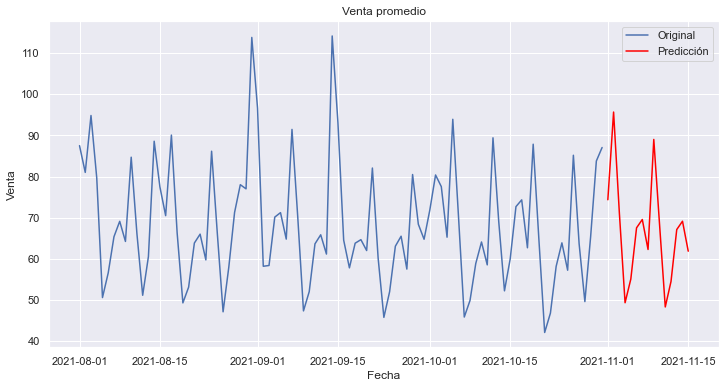

In [29]:
y_pred = results.get_forecast(len(dia_pred))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1], dynamic=False)
y_pred_df.index = dia_pred
y_pred_out = y_pred_df["Predictions"] 
plt.figure(figsize=(12,6))
plt.plot(venta_promedio.index, venta_promedio.values, label='Original')
plt.plot(y_pred_out, color='Red', label = 'Predicción')
plt.ylabel('Venta')
plt.xlabel('Fecha')
plt.title('Venta promedio')
plt.legend()

In [30]:
prediccion = pd.DataFrame({'Fecha':dia_pred, 'Pred_venta':y_pred_out.values})
prediccion

,Fecha,Pred_venta
0,2021-11-01,74.373124
1,2021-11-02,95.695826
2,2021-11-03,71.308048
3,2021-11-04,49.331795
4,2021-11-05,55.080012
5,2021-11-06,67.546255
6,2021-11-07,69.568558
7,2021-11-08,62.281847
8,2021-11-09,89.035793
9,2021-11-10,68.461266


# Venta promedio por tipo de tienda por día
En la siguiente aproximación analizaremos y predeciremos el comportamiento de ventas promedio por día por cada tipo de tienda, se encontraron 6 tipo de tienda:
Hiper    [Plus, Basico, Intermedio]
Super    [Basico, Intermedio, Plus].

Recuperamso el data set original para agrupar y encontrar los valores necesarios.


In [31]:
df_ventas.head()

,Formato,Subformato,Producto,id_fec_diaria,Venta,Precio,Venta_aa,Precio_aa
0,Super,Basico,369772,2021-08-01,7.0,17.168571,5.0,21.063200
1,Super,Basico,369772,2021-08-02,6.0,17.141667,3.0,21.388667
2,Super,Basico,369772,2021-08-03,5.0,17.136000,5.0,21.376199
3,Super,Basico,369772,2021-08-04,4.0,16.995000,3.0,21.360367
4,Super,Basico,369772,2021-08-05,1.0,17.240000,1.0,21.397100


In [32]:
aux_ventas_tienda = df_ventas.groupby(['Formato', 'Subformato', 'id_fec_diaria']).mean() 
aux_ventas_tienda.index.names

a = aux_ventas_tienda.loc[('Hiper', 'Basico'), 'Venta']
b = aux_ventas_tienda.loc[('Hiper', 'Intermedio'), 'Venta']
c = aux_ventas_tienda.loc[('Hiper', 'Plus'), 'Venta']
d = aux_ventas_tienda.loc[('Super', 'Basico'), 'Venta']
e = aux_ventas_tienda.loc[('Super', 'Intermedio'), 'Venta']
f = aux_ventas_tienda.loc[('Super', 'Plus'), 'Venta']

venta_por_tienda = pd.DataFrame(
    {'Hiper Basico':a,
     'Hiper Intermedio':b,
     'Hiper Plus':c,
     'Super Basico':d,
     'Super Intermedio':e,
     'Super Plus':f})
venta_por_tienda.head()
nombre_tienda = venta_por_tienda.keys()

In [33]:
venta_por_tienda.describe()

,Hiper Basico,Hiper Intermedio,Hiper Plus,Super Basico,Super Intermedio,Super Plus
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,109.359168,57.394899,55.490420,12.385391,29.002278,43.185987
std,22.065029,13.242550,18.385980,2.094216,7.659697,11.066672
min,66.253490,33.611036,34.478369,7.857644,20.280962,30.912023
25%,95.873038,47.936561,43.834806,11.077623,23.448726,34.786222
50%,105.787256,55.872315,49.006242,12.171432,24.894683,38.079668
75%,123.187102,66.510189,61.257193,13.599188,33.545163,47.606907
max,176.202453,96.339284,117.935260,18.377551,50.073644,73.959631


Separamos el data set en prueba y entrenamiento.

In [34]:
train = venta_por_tienda[:-17]
test = venta_por_tienda[-17:]

## Descomposición de las series
Al igual que en el análisis para las ventas promedio vamos a descomponer las series en sus componentes, como tienen un comportamiento parecido al del análisis anterior utilizaremos de igual forma un modelo multiplicativo.

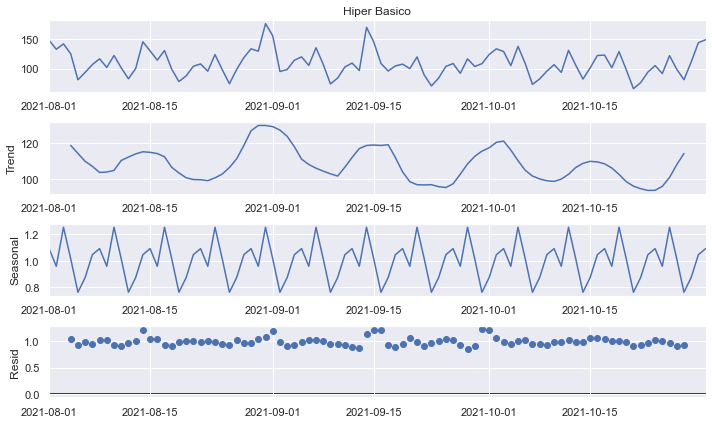

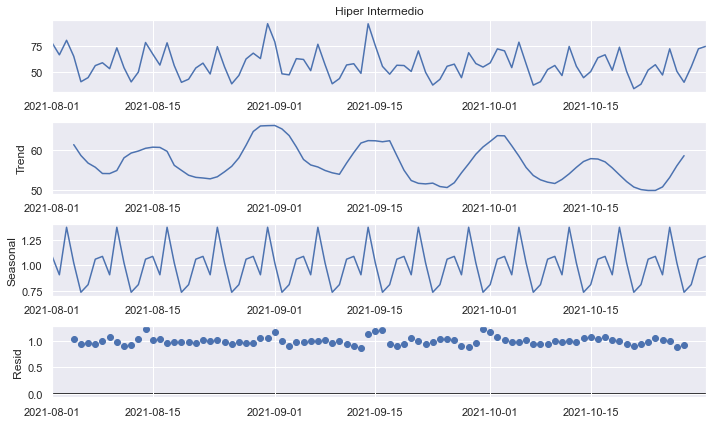

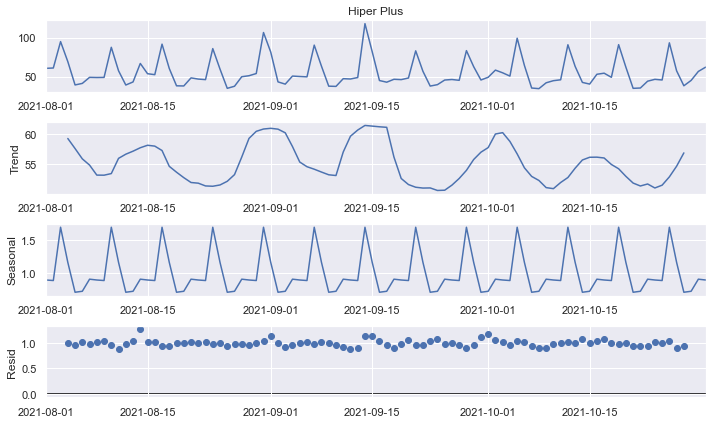

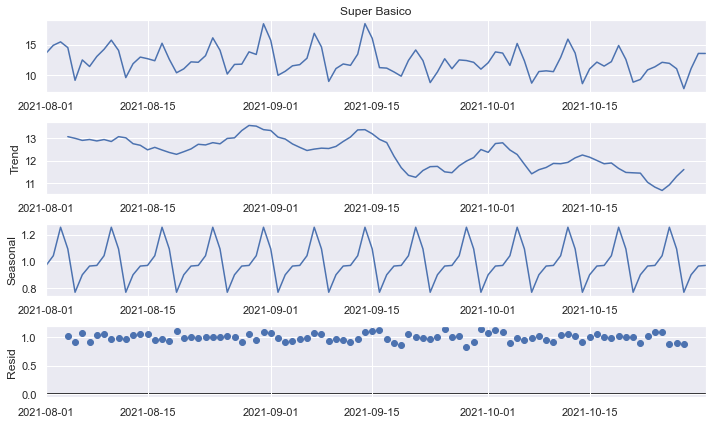

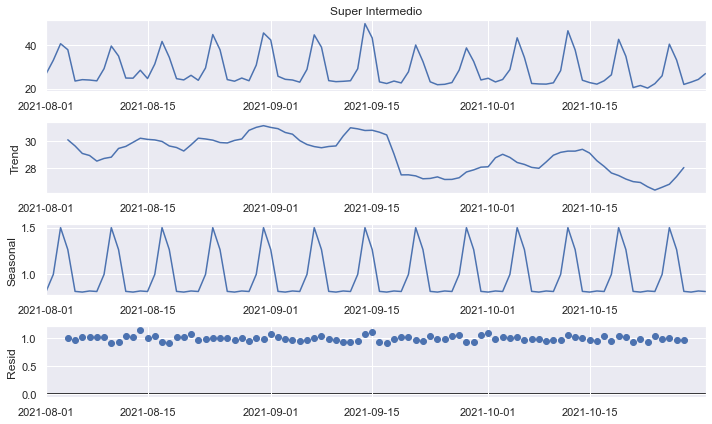

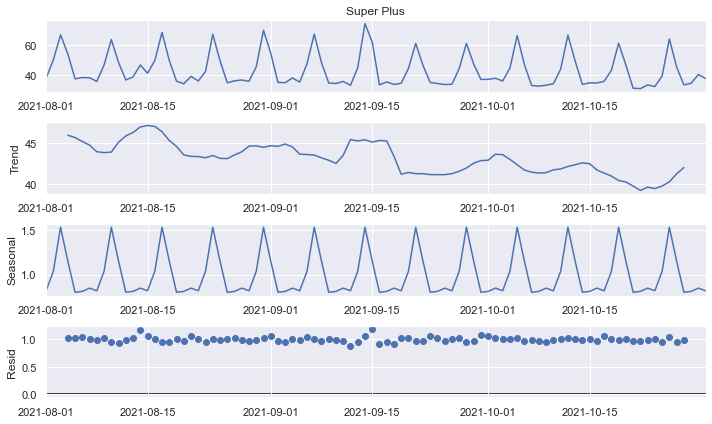

In [35]:
from matplotlib.pylab import title
def descomposition_series(df, col):
  rcParams['figure.figsize'] = 10, 6
  decomposition_model = sm.tsa.seasonal_decompose(df[col], model='multiplicative')
  decomposition_plot_func = decomposition_model.plot()
  
for nombre in nombre_tienda:
  descomposition_series(venta_por_tienda, nombre)
  

## Estadísticas de las series
Para saber el tipo de ruido en las misma.

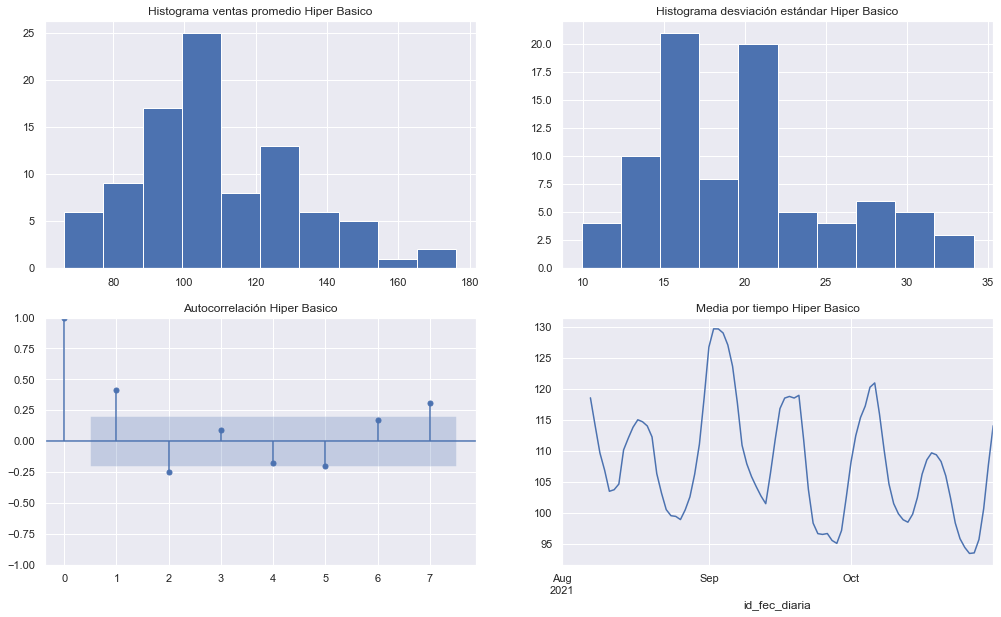

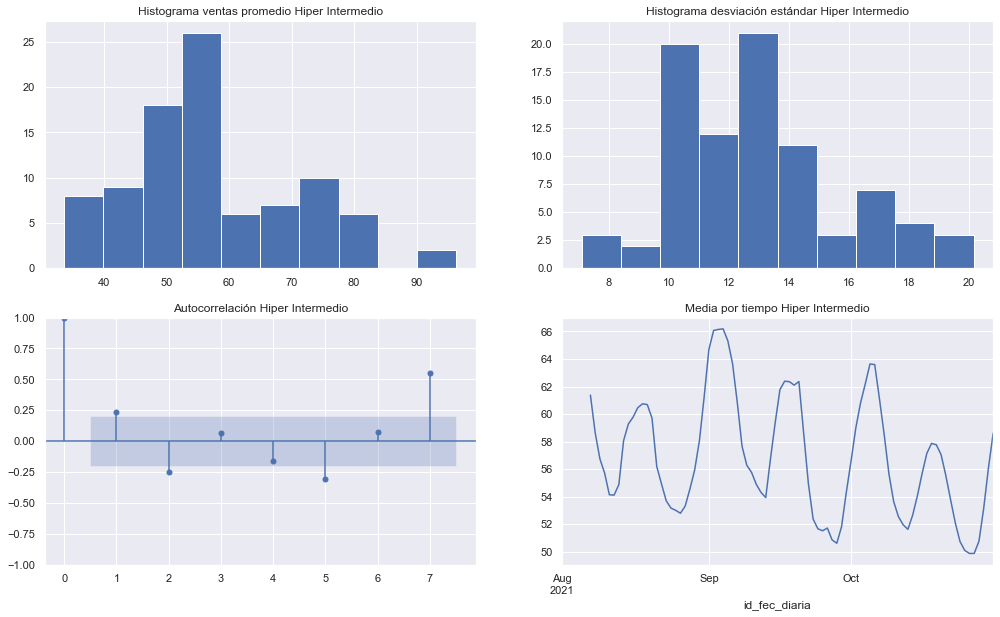

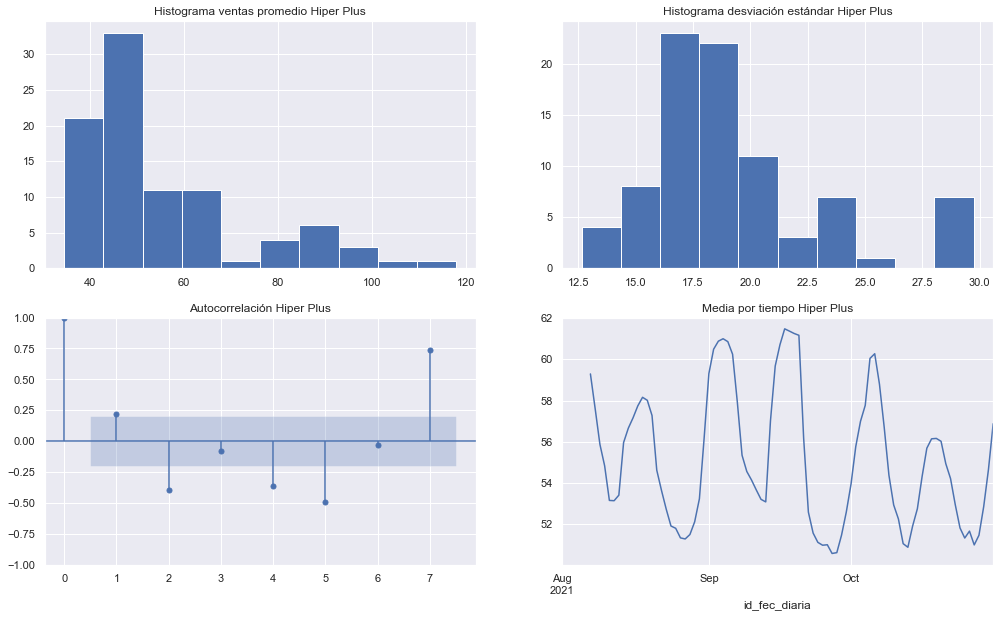

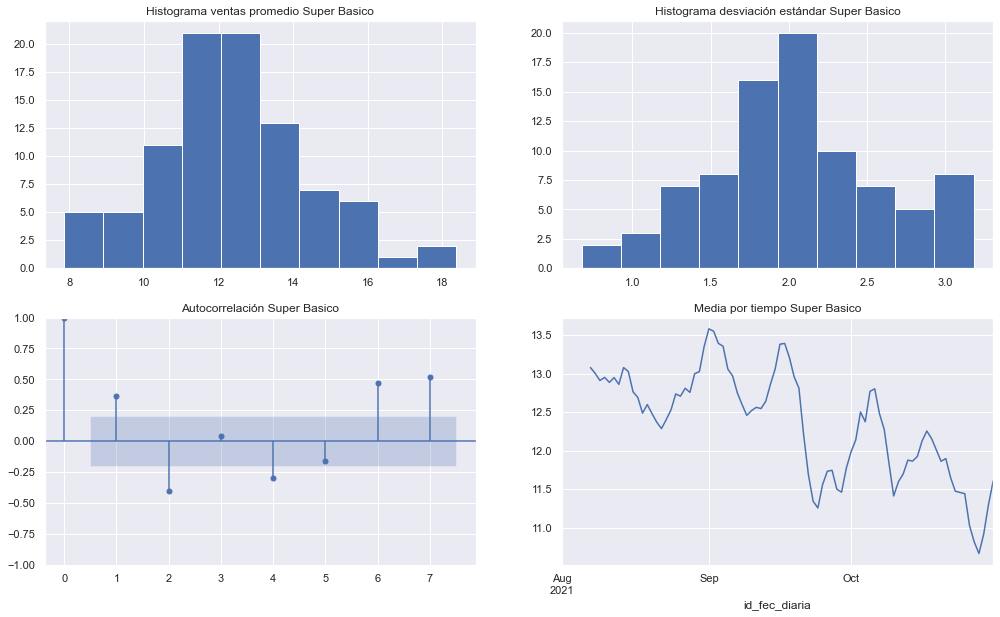

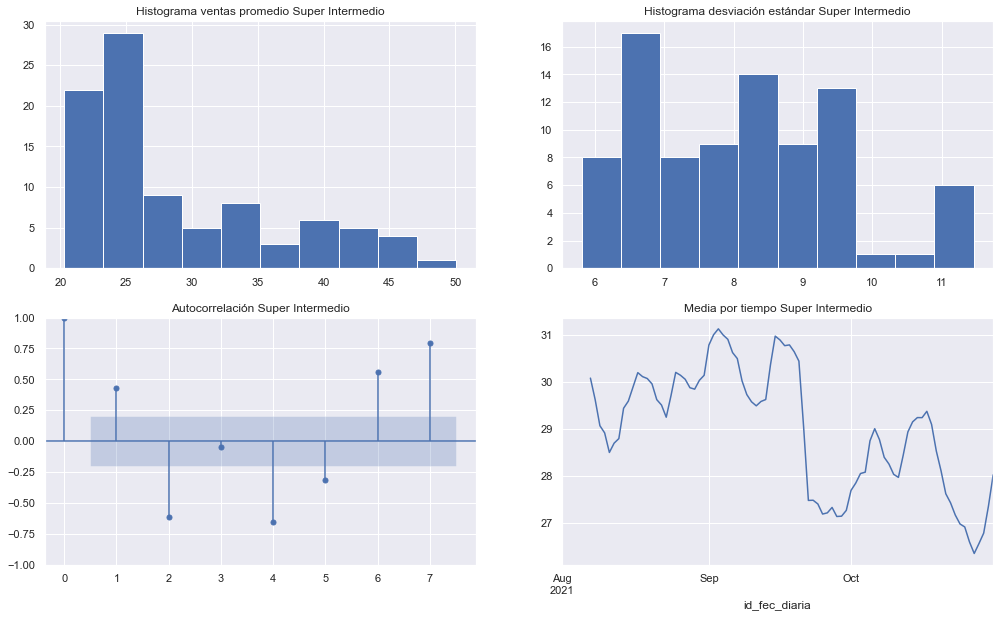

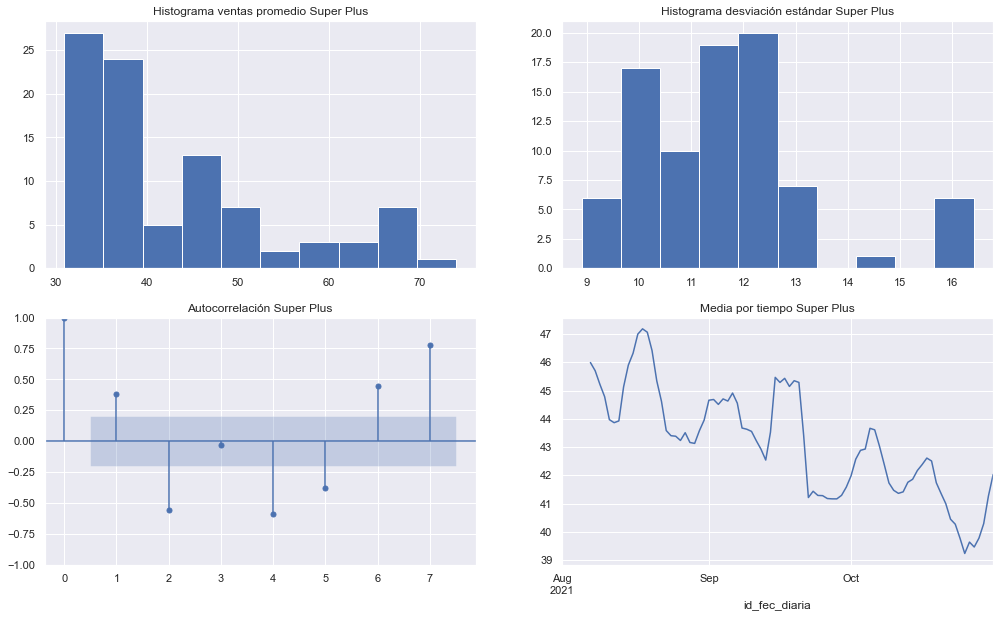

In [36]:
def estadisticas_serie(df, col):
  fig = plt.figure(figsize=(17, 10))
  layout = (2,2)
  hist_ax = plt.subplot2grid(layout, (0,0))
  ac_ax = plt.subplot2grid(layout, (1,0))
  hist_std_ax = plt.subplot2grid(layout, (0,1))
  mean_ax = plt.subplot2grid(layout, (1,1))
  df[col].hist(ax=hist_ax)
  hist_ax.set_title(f"Histograma ventas promedio {col}")
  plot_pacf(df[col], lags = 7, ax = ac_ax)
  ac_ax.set_title(f"Autocorrelación {col}")
  mm = df[col].rolling(7).std()
  mm.hist(ax=hist_std_ax)
  hist_std_ax.set_title(f"Histograma desviación estándar {col}")
  mm = df[col].rolling(7).mean()
  mm.plot(ax=mean_ax)
  mean_ax.set_title(f"Media por tiempo {col}")

for elemento in nombre_tienda:
  estadisticas_serie(venta_por_tienda, elemento)

No se detecta ruido blanco, se observa que las variables no son independientes.

## Deteccion de anomalías 
Analizamos las series de tiempo para encontrar valores inusuales en ellas.

Series([], Name: Hiper Basico, dtype: float64)
Series([], Name: Hiper Intermedio, dtype: float64)
id_fec_diaria
2021-08-31    106.555989
2021-09-14    117.935260
Name: Hiper Plus, dtype: float64
Series([], Name: Super Basico, dtype: float64)
Series([], Name: Super Intermedio, dtype: float64)
Series([], Name: Super Plus, dtype: float64)


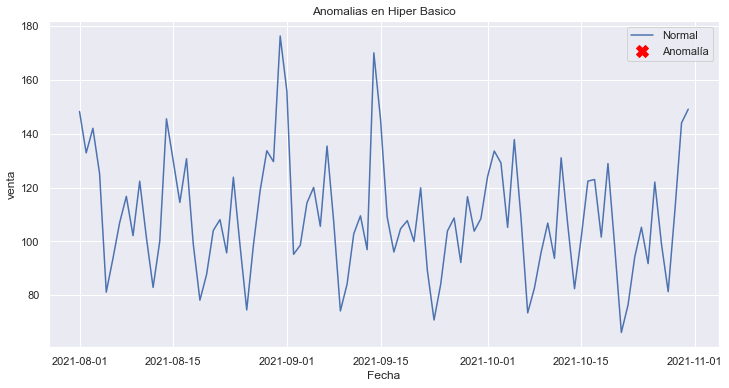

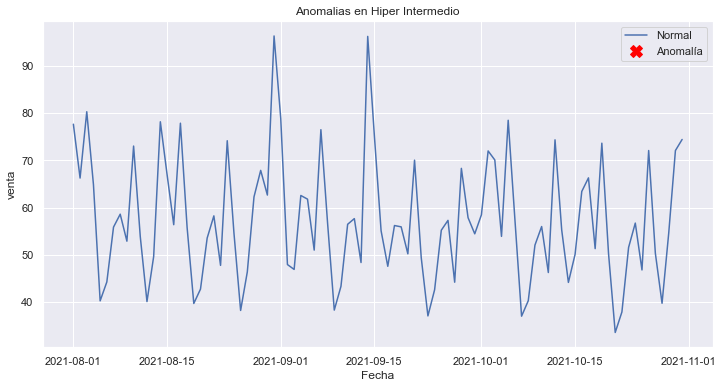

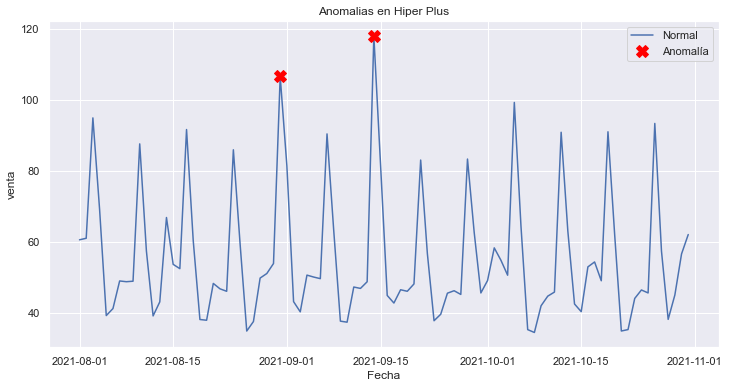

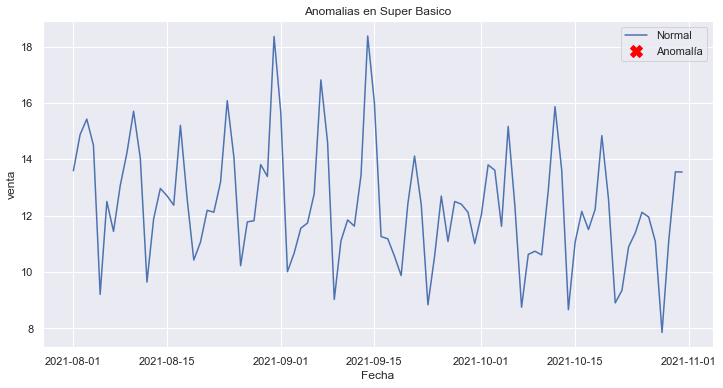

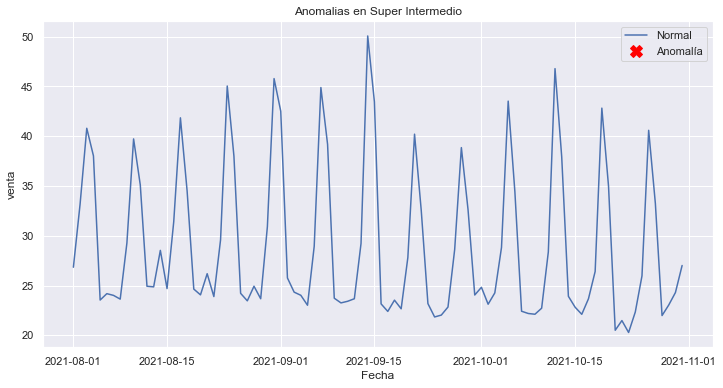

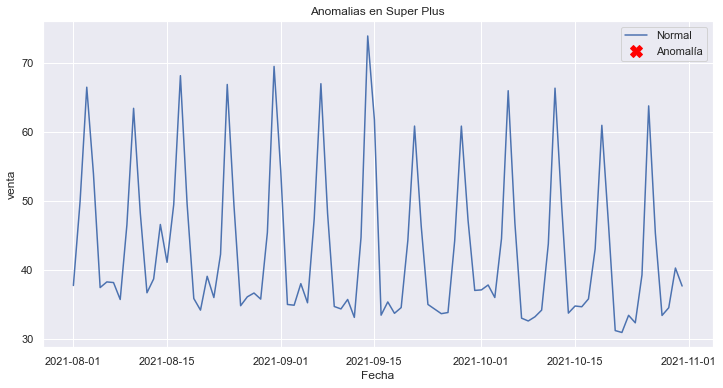

In [37]:
def det_anomalias(df, col):
  q1_pc1, q3_pc1 = df[col].quantile([0.25, 0.83])
  iqr_pc1 = q3_pc1 - q1_pc1
  lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
  upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
  anomaly = ((df[col]>upper_pc1) | (df[col]<lower_pc1)).astype('int')
  anomal = df[col][anomaly == 1]
  plt.figure(figsize=(12,6))
  plt.plot(df[col], label='Normal')
  plt.plot(anomal, linestyle='none', marker='X', color='red',
  markersize=12, label='Anomalía')
  plt.xlabel('Fecha')
  plt.ylabel('venta')
  plt.title(f"Anomalias en {col}")
  plt.legend(loc='best')
  print(anomal)


for elemento in nombre_tienda:
  det_anomalias(venta_por_tienda, elemento)

Se observan más anomalías en estas series temporales, pero si observamos detenidamente las fechas sigues estando entorno a finales de Agosto (regreso a clases) y mediados de Septiembre (Independencia Mexicana), esto claro como hipótesis.

## Pronostico
Utilizaremos las mismas técnicas para este análisis que en la aproximación pasada.

## SARIMAX

In [38]:
def train_pred_sarimax(df_train, df_test, col):
# fit model
  model=sm.tsa.statespace.SARIMAX(
      df_train[col],
      order=(0, 1, 6),
      seasonal_order=(0,1,1,7))

  results=model.fit()
  
  y_pred = results.get_forecast(len(df_test[col].index))
  y_pred_df = y_pred.conf_int(alpha = 0.05) 
  y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1], dynamic=False)
  y_pred_df.index = df_test.index
  y_pred_out = y_pred_df["Predictions"] 

  msle_sarimax = mean_squared_log_error(df_test[col].values, y_pred_df['Predictions'].values)
  
  return msle_sarimax

sarimax_msle_lista = []
for elemento in nombre_tienda:
   sarimax_msle_lista.append(train_pred_sarimax(train, test, elemento))

In [39]:
sarimax_mean_msle = sum(sarimax_msle_lista)/len(sarimax_msle_lista)
sarimax_mean_msle

0.011332301055151693

## Pronóstico 01 al 15 de Noviembre del 2021

In [40]:
from datetime import date, timedelta

sdate = date(2021,11,1)   
edate = date(2021,11,16)
dia_pred = pd.date_range(sdate,edate-timedelta(days=1),freq='d')
dia_pred

DatetimeIndex(['2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
               '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08',
               '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15'],
              dtype='datetime64[ns]', freq='D')

In [41]:
Predicciones_por_tienda = pd.DataFrame({'Fecha':dia_pred})

for elemento in nombre_tienda:
  model=sm.tsa.statespace.SARIMAX(
    venta_por_tienda[elemento],
    order=(0, 1, 6),
    seasonal_order=(0,1,1,7))

  results=model.fit()

  y_pred = results.get_forecast(len(dia_pred))
  y_pred_df = y_pred.conf_int(alpha = 0.05) 
  y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1], dynamic=False)
  y_pred_df.index = dia_pred
  y_pred_out = y_pred_df["Predictions"] 

  Predicciones_por_tienda[elemento] = y_pred_out.values
  

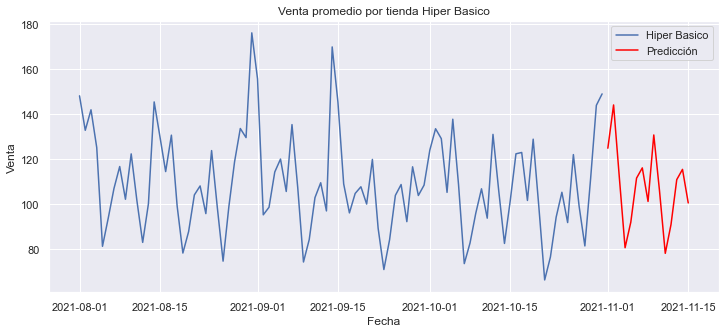

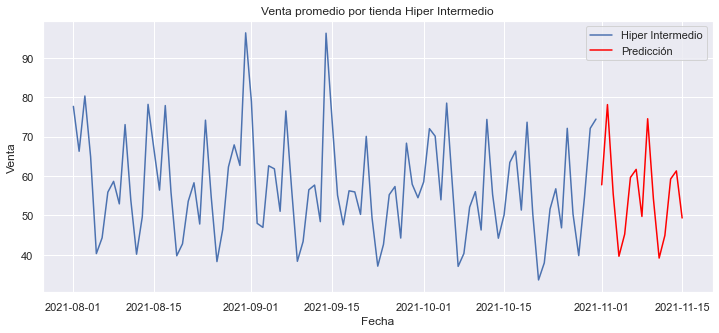

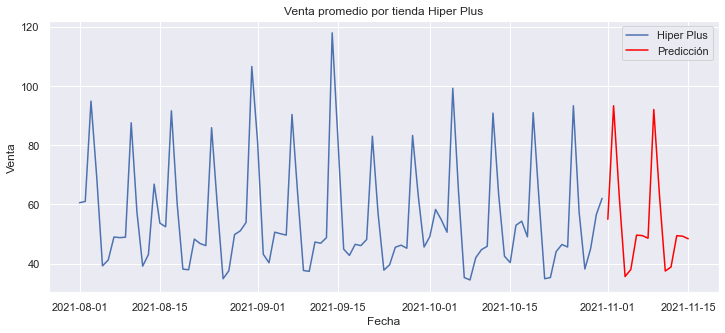

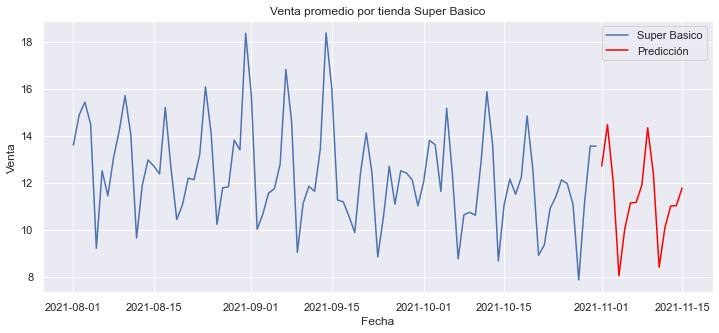

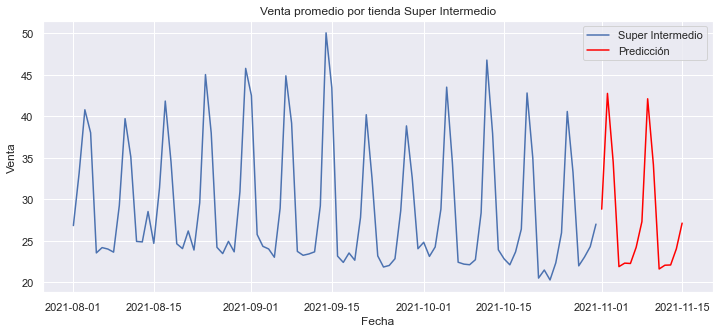

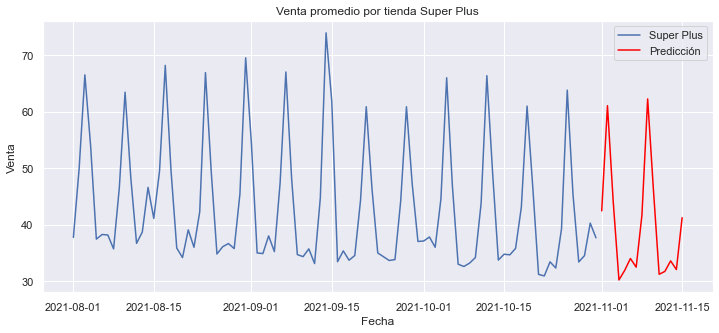

In [42]:
for nombre in nombre_tienda:
  plt.figure(figsize=(12, 5)) 
  plt.plot(venta_por_tienda[nombre].index, venta_por_tienda[nombre].values, label=f'{nombre}')
  plt.plot(Predicciones_por_tienda['Fecha'], Predicciones_por_tienda[nombre].values, color='Red', label = 'Predicción')
  plt.ylabel('Venta')
  plt.xlabel('Fecha')
  plt.title(f'Venta promedio por tienda {nombre}')
  plt.legend()
  plt.show()

In [43]:
Predicciones_por_tienda.to_csv('Predicciones_por_tipo_de_tienda.csv')
Predicciones_por_tienda

,Fecha,Hiper Basico,Hiper Intermedio,Hiper Plus,Super Basico,Super Intermedio,Super Plus
0,2021-11-01,124.870813,57.761574,54.970133,12.706568,28.817024,42.433352
1,2021-11-02,144.123924,78.125109,93.324599,14.466909,42.771526,61.059252
2,2021-11-03,111.913895,55.462619,62.407214,12.033725,34.479287,44.109719
3,2021-11-04,80.587677,39.622666,35.633862,8.034188,21.885778,30.199168
4,2021-11-05,91.977807,45.235066,37.995868,10.010651,22.307138,31.892766
5,2021-11-06,111.561468,59.622079,49.612371,11.132951,22.266863,33.995665
6,2021-11-07,116.121699,61.677347,49.458533,11.159551,24.220156,32.464866
7,2021-11-08,101.187438,49.727528,48.577503,11.908858,27.312576,41.643979
8,2021-11-09,130.762167,74.537149,92.041926,14.334368,42.125572,62.260747
9,2021-11-10,105.831554,54.238691,62.825532,12.377235,34.165939,46.242744


# Transformación de datos

In [44]:
def transformador(df_in):
  df = pd.DataFrame({})
  df['date'] = pd.to_datetime(df_in.index)
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['sin_day'] = np.sin(df['dayofyear'])
  df['cos_day'] = np.cos(df['dayofyear'])
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  X = df.drop(['date'],axis=1)
  y = df_in.values
  return [X, y]

dir_x_y = {}
for elemento in nombre_tienda:
  dir_x_y[elemento] = transformador(venta_por_tienda[elemento])


In [45]:
def escalador(directorio, col):
  X_aux = directorio[col][0]
  y_aux = directorio[col][1]

  X_train_df, X_test_df, y_train, y_test = X_aux.values[:-17], X_aux.values[-17:], y_aux[:-17], y_aux[-17:]
  scaler = StandardScaler()

  scaler.fit(X_train_df)
  X_train = scaler.transform(X_train_df)
  X_test = scaler.transform(X_test_df)

  return [X_train, X_test, y_train, y_test]

lista_x_y = []
for elemento in nombre_tienda:
  lista_x_y.append(escalador(dir_x_y, elemento))


## XGBoost

In [46]:
# XGBoost
xgboost_msle = []
for num in range(0, 6):
  reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
  reg.fit(lista_x_y[num][0], lista_x_y[num][2], verbose=False) 

  yhat = reg.predict(lista_x_y[num][1])
  msle1 = mean_squared_log_error(lista_x_y[num][3], yhat)
  xgboost_msle.append(msle1)

sum(xgboost_msle)/len(xgboost_msle)

0.011416768460469115

## KNN

In [47]:
knn_lista_msle = []
for num in range(0,6):
  reg = KNeighborsRegressor(n_neighbors=2)
  reg.fit(lista_x_y[num][0], lista_x_y[num][2])
  yhat = reg.predict(lista_x_y[num][1])

  msle2 = mean_squared_log_error(lista_x_y[num][3], yhat)
  knn_lista_msle.append(msle2)

sum(knn_lista_msle)/len(knn_lista_msle)


0.04080114424132258

# Venta por top diez productos más vendidos
Realizamos este análisis encontrando el top diez productos más vendidos (En un caso real el análisis para preparar la demanda debería ser con muchos más) y realizar su pronóstico.

In [48]:
prod_aux = df_ventas.groupby(['Producto']).sum()

nombre_top_producto = prod_aux.sort_values(by='Venta')[-10:].index
nombre_top_producto

prod_aux = df_ventas.groupby(['Producto', 'id_fec_diaria']).mean()

venta_por_producto = pd.DataFrame({})
for elemento in nombre_top_producto:
  venta_por_producto[elemento] = prod_aux.loc[(elemento), 'Venta']
venta_por_producto

venta_por_producto.head()

,385938,373557,348,303949,245837,116,407,207185,480,456
id_fec_diaria,,,,,,,,,,
2021-08-01,784.166667,1358.500000,1510.783007,1850.439665,1171.4,866.803169,1320.617826,667.844000,2013.098660,2346.050648
2021-08-02,780.200000,761.666667,1246.522320,1586.039334,1181.8,887.927830,1286.422663,2504.923332,1866.232506,2234.195340
2021-08-03,806.400000,783.000000,2675.579670,2484.060020,1073.0,1963.007844,5737.543344,1805.445000,5689.876649,4099.069846
2021-08-04,572.000000,573.166667,1835.476664,1393.731327,1059.0,1208.160001,4491.510682,2144.529999,3673.121326,2987.180860
2021-08-05,335.666667,415.333333,734.359665,982.142663,982.8,445.078333,865.064169,1810.071665,1248.912501,1621.925835


Separamos el set para el entrenamiento y la prueba

In [49]:
train = venta_por_producto[:-17]
test = venta_por_producto[-17:]

## Descomposición de las Series

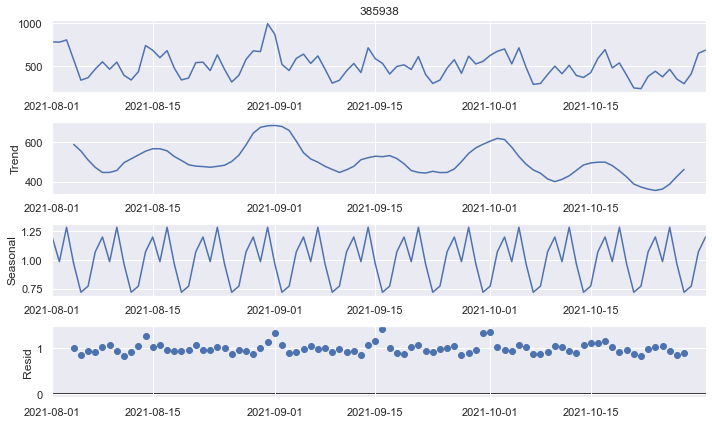

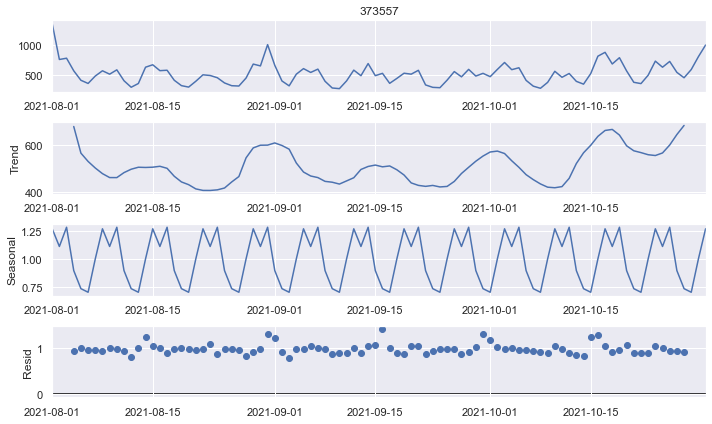

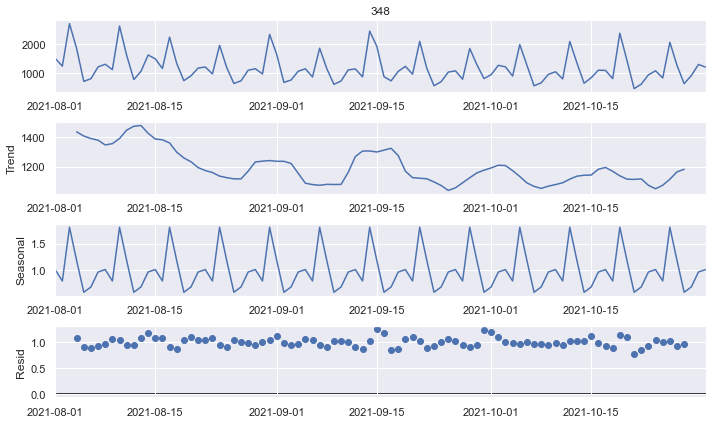

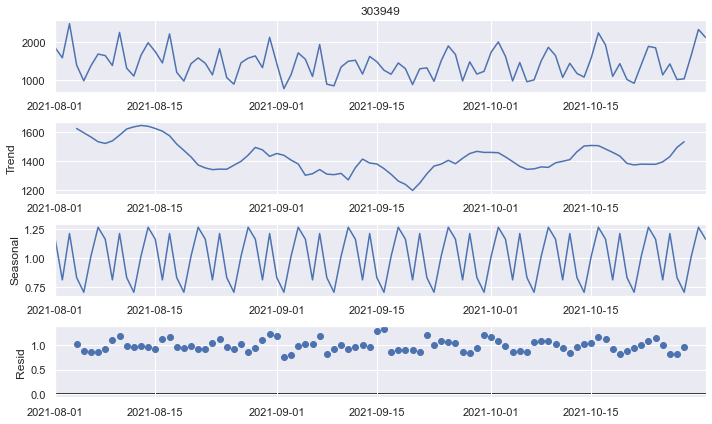

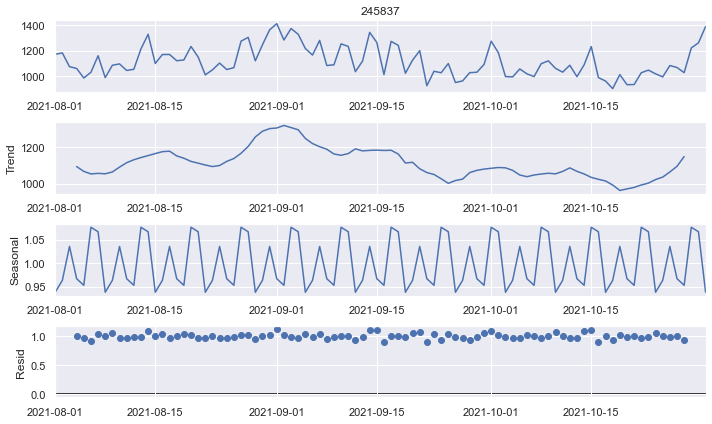

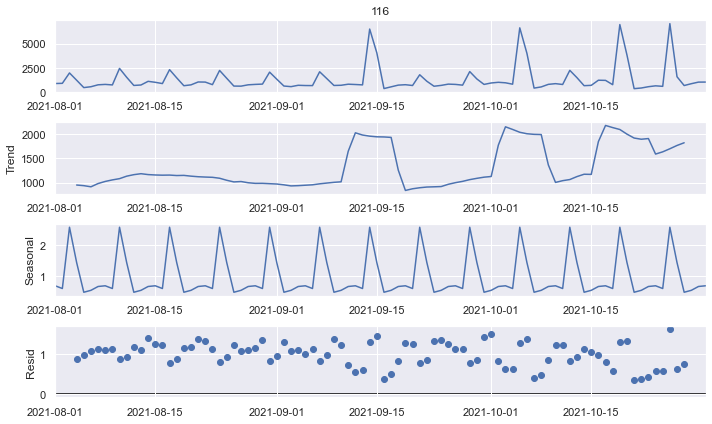

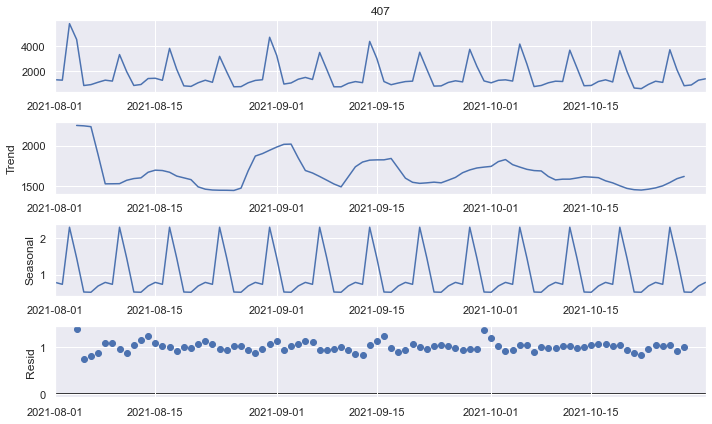

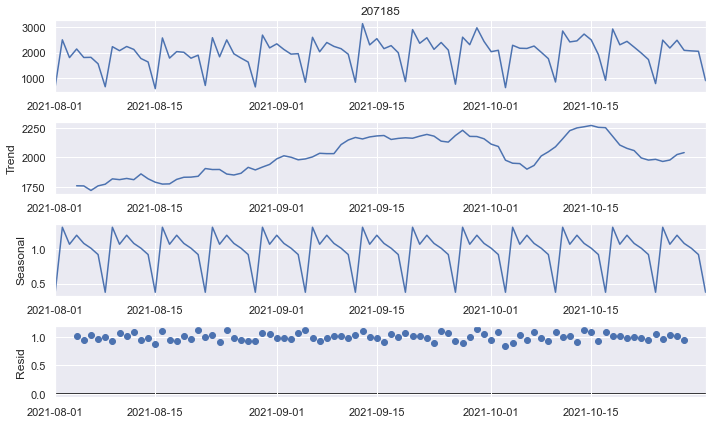

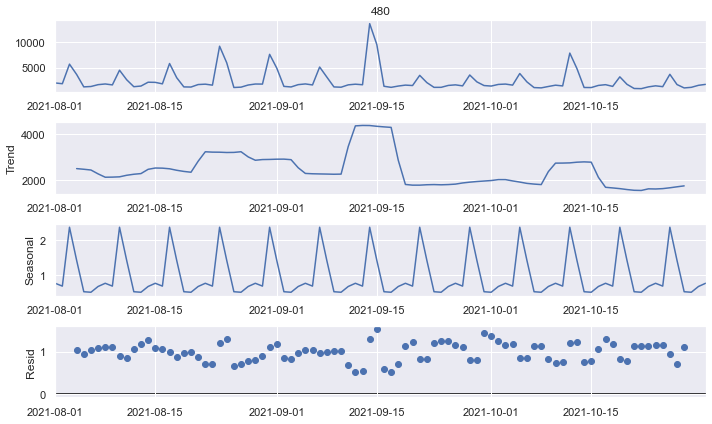

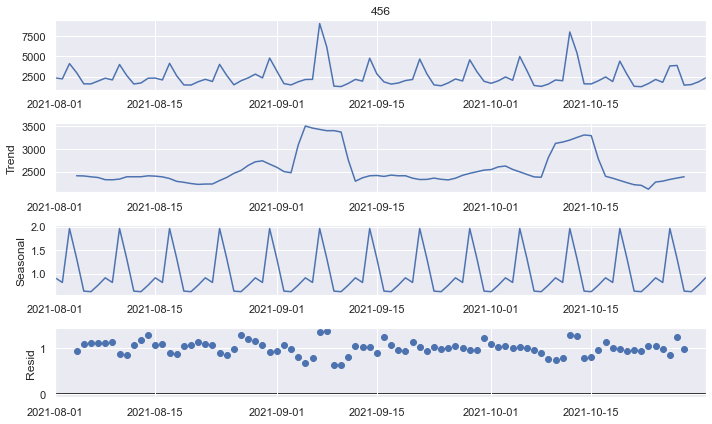

In [50]:
for nombre in nombre_top_producto:
  descomposition_series(venta_por_producto, nombre)

## Estadísticas de las series

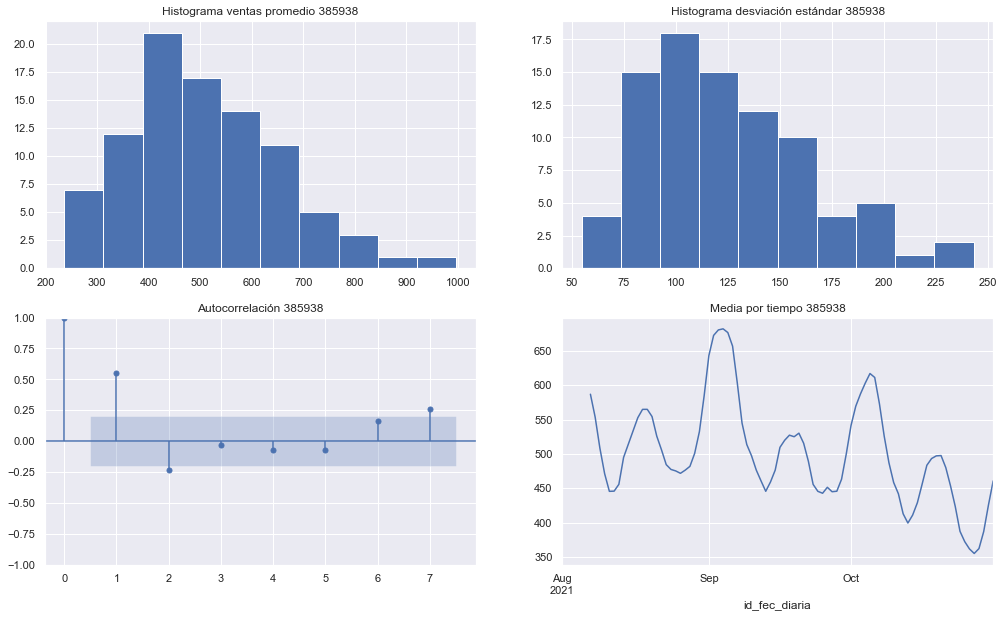

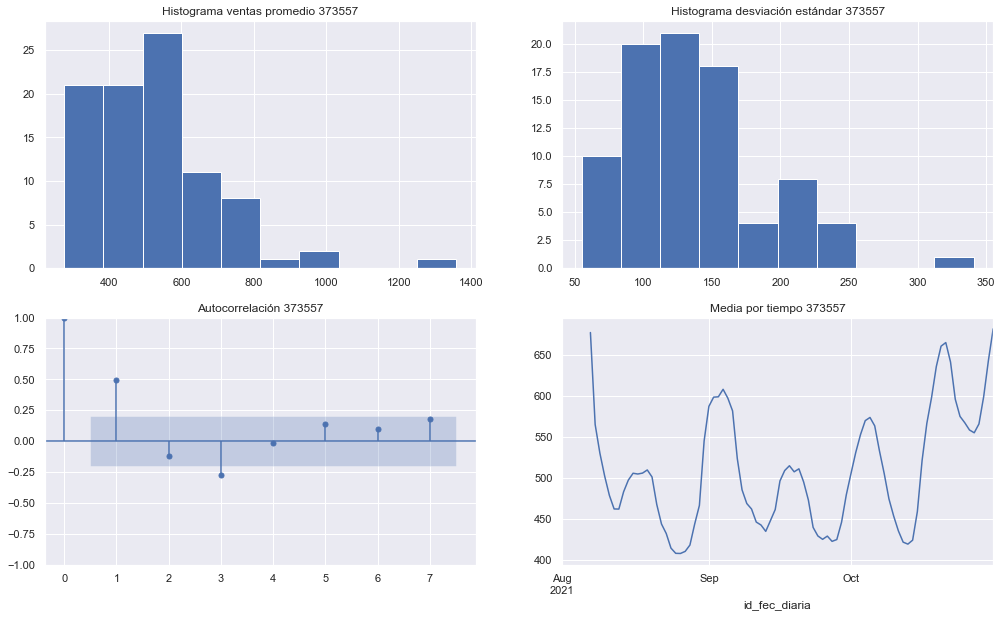

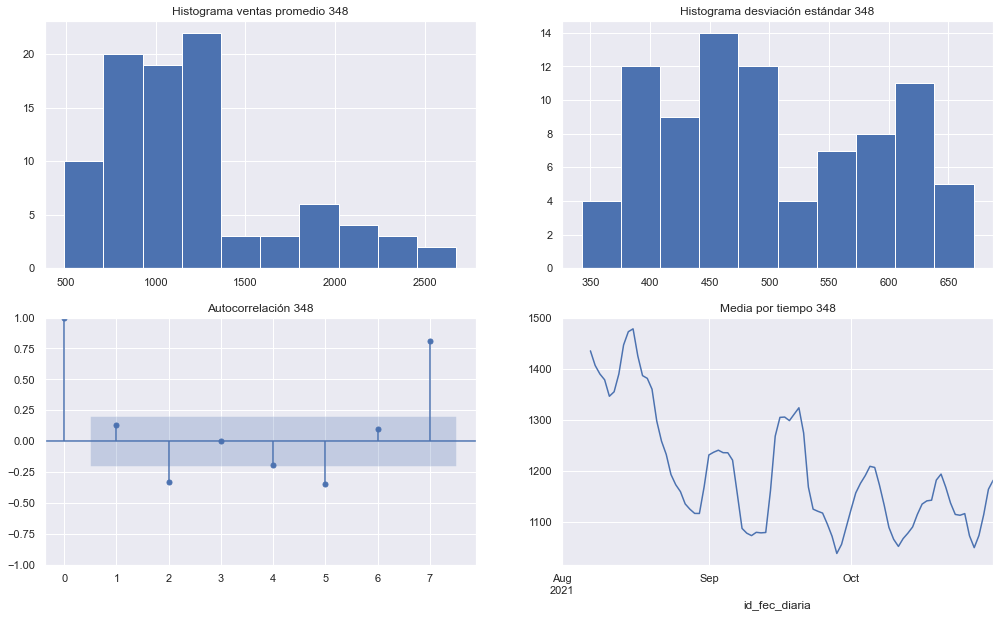

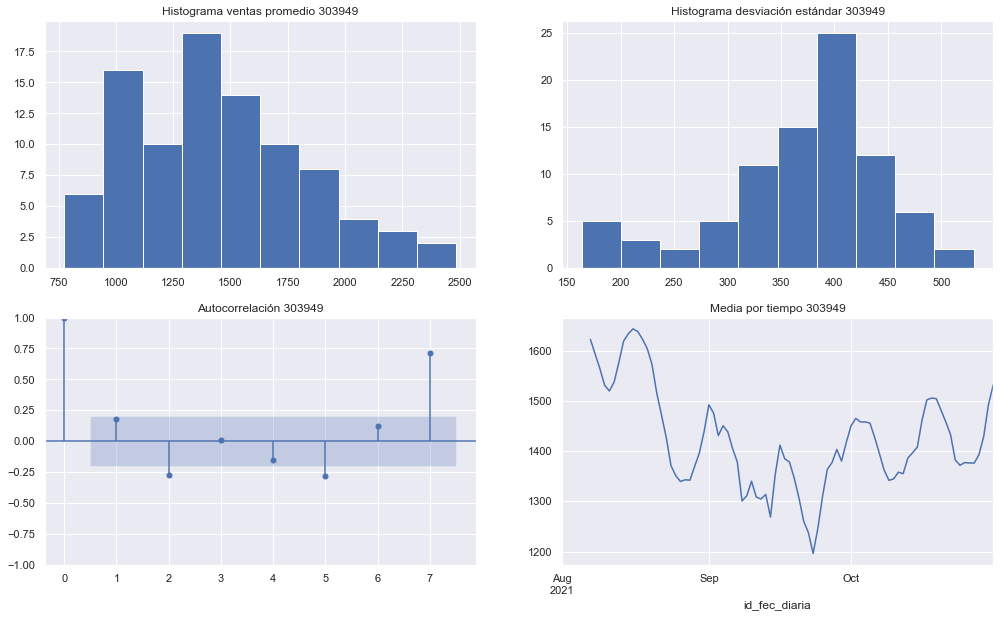

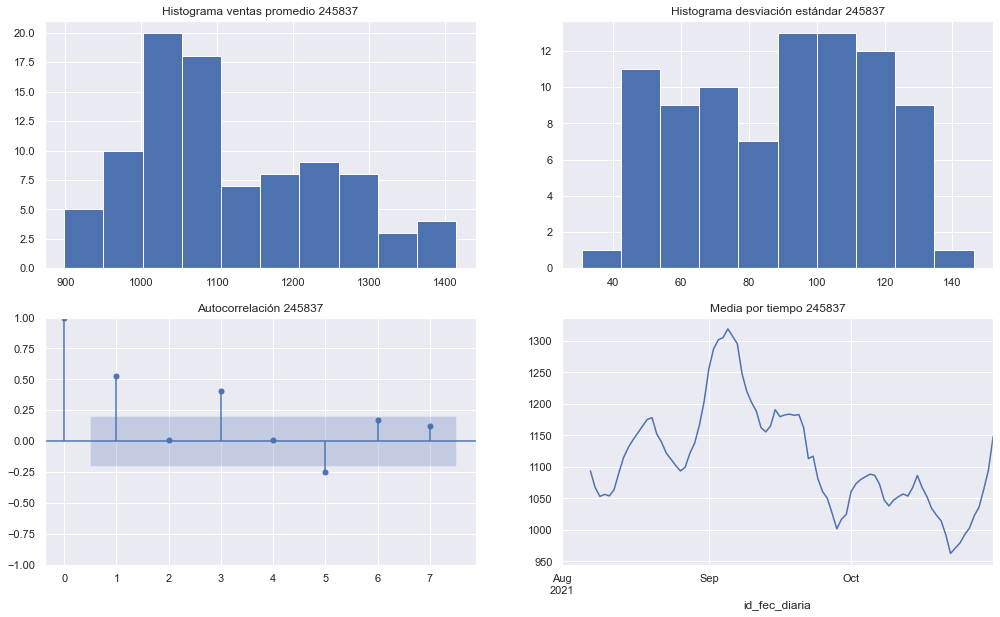

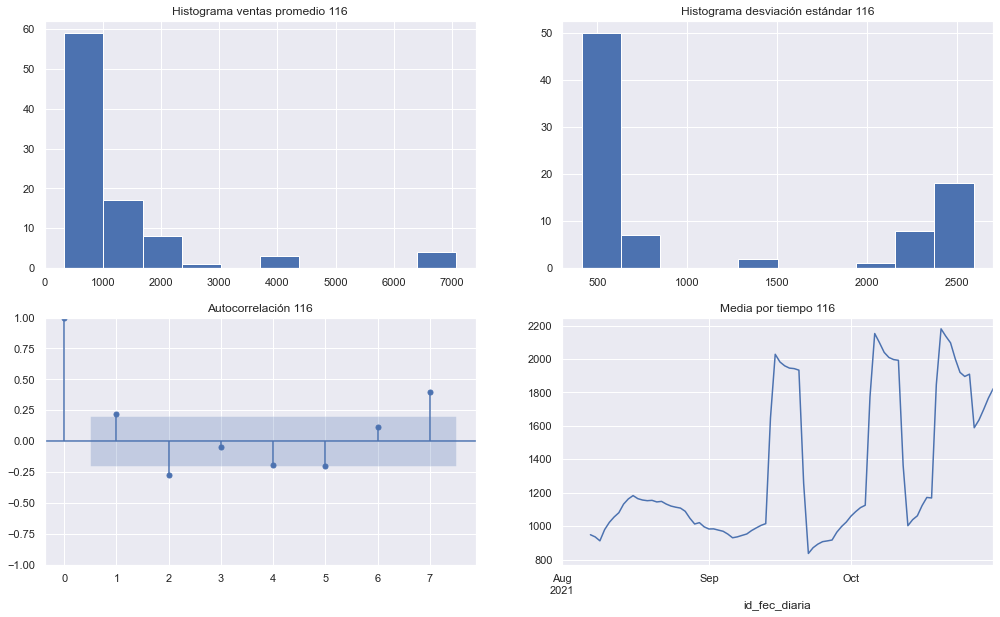

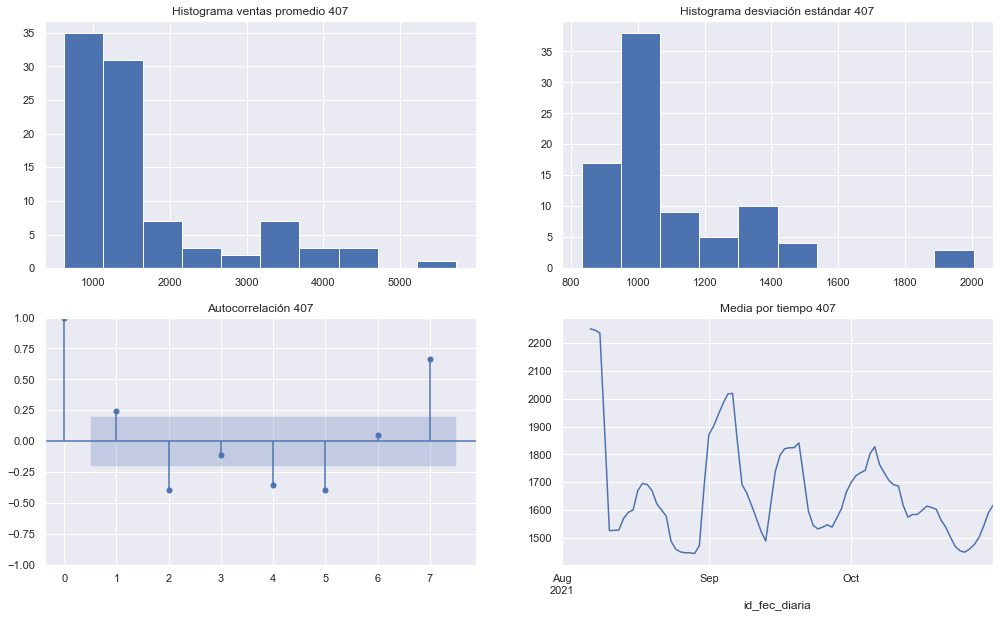

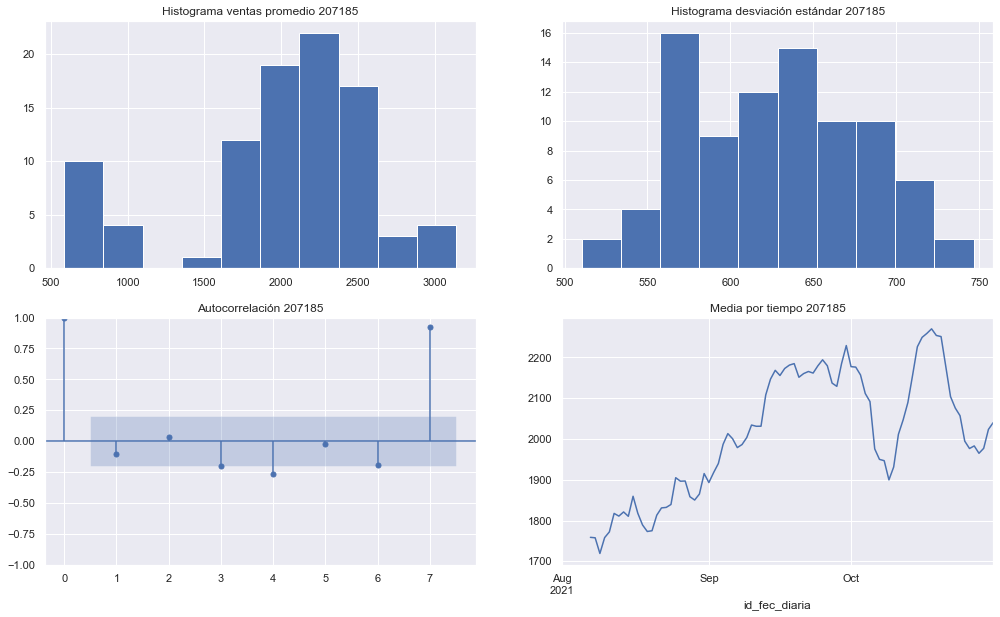

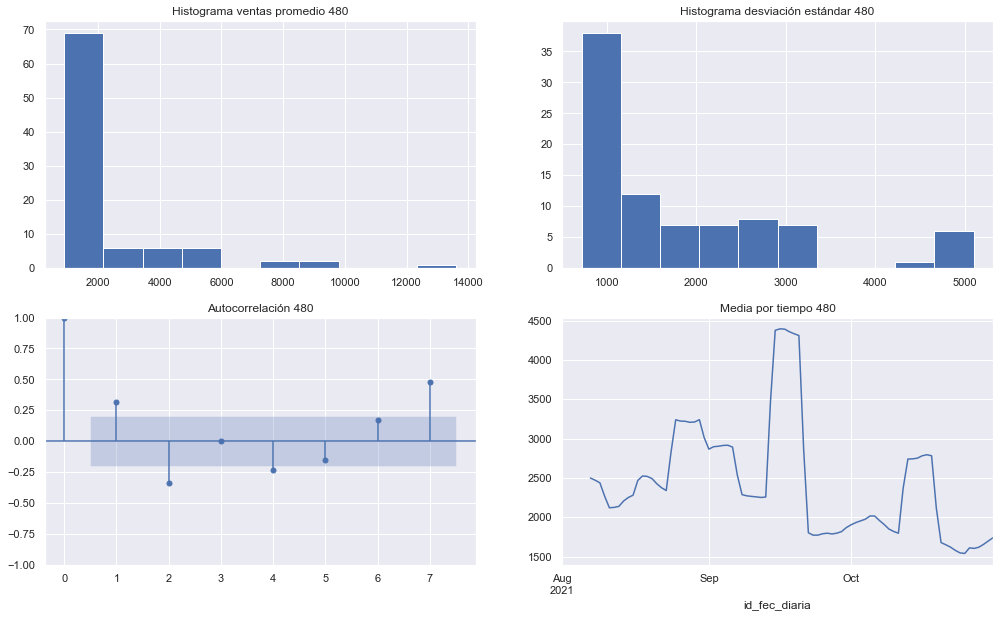

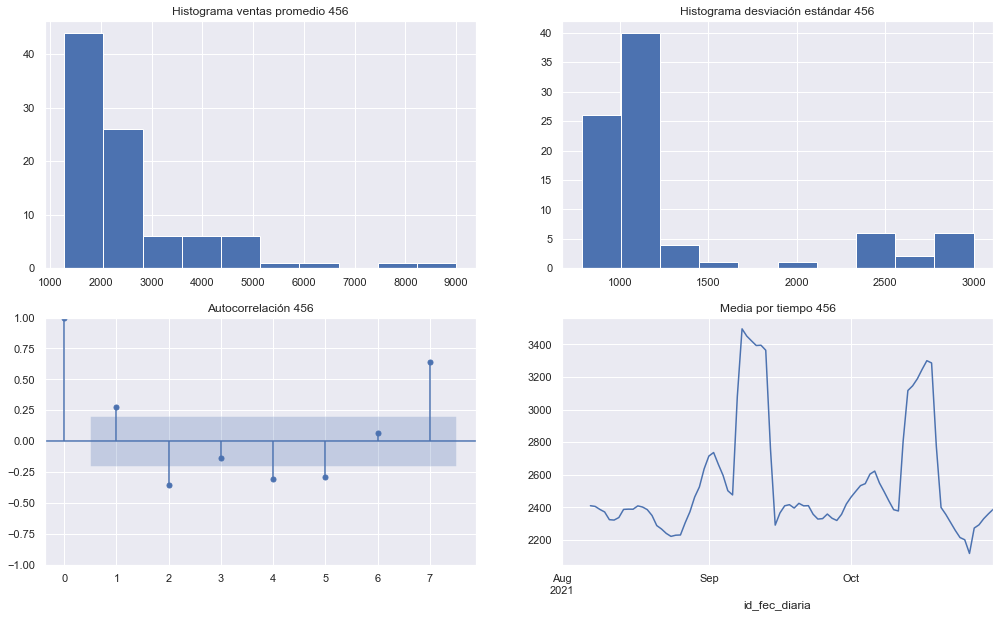

In [51]:
for elemento in nombre_top_producto:
  estadisticas_serie(venta_por_producto, elemento)

Se muestra en las gráficas anteriores que ninguna presenta white noise por lo que procedemos a realizar los demás análisis.

## Detección de anomalías

Series([], Name: 385938, dtype: float64)
id_fec_diaria
2021-08-01    1358.5
Name: 373557, dtype: float64
Series([], Name: 348, dtype: float64)
Series([], Name: 303949, dtype: float64)
Series([], Name: 245837, dtype: float64)
id_fec_diaria
2021-09-14    6510.512047
2021-09-15    4045.297343
2021-10-05    6636.835375
2021-10-06    3997.007817
2021-10-19    6976.322985
2021-10-20    3813.339991
2021-10-26    7071.766986
Name: 116, dtype: float64
id_fec_diaria
2021-08-03    5737.543344
Name: 407, dtype: float64
id_fec_diaria
2021-08-01    667.844000
2021-08-08    660.004004
2021-08-15    585.238000
2021-08-22    710.312000
2021-08-29    653.129999
2021-10-03    626.156002
Name: 207185, dtype: float64
id_fec_diaria
2021-08-24     9196.537992
2021-08-31     7610.703178
2021-09-14    13609.007548
2021-09-15     9519.042112
2021-10-12     7854.579277
Name: 480, dtype: float64
id_fec_diaria
2021-09-07    9003.043793
2021-10-12    7974.689667
Name: 456, dtype: float64


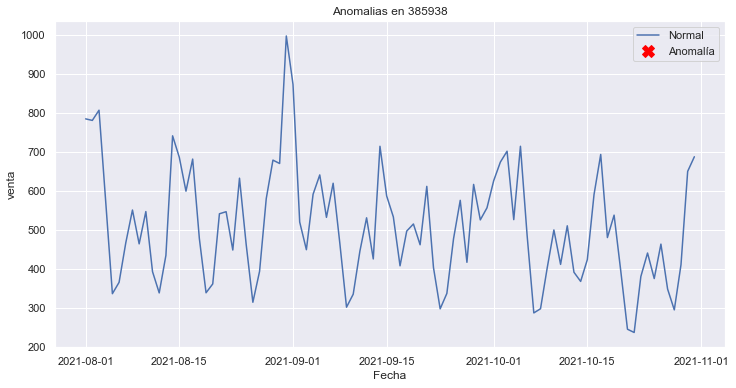

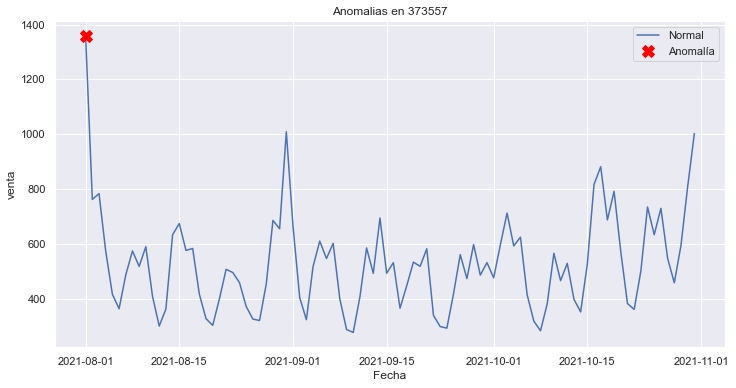

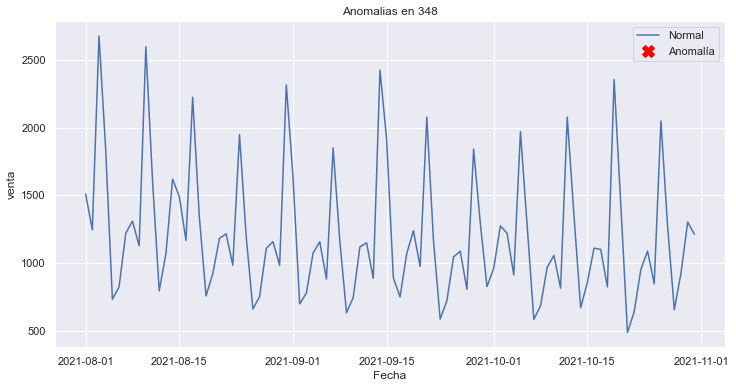

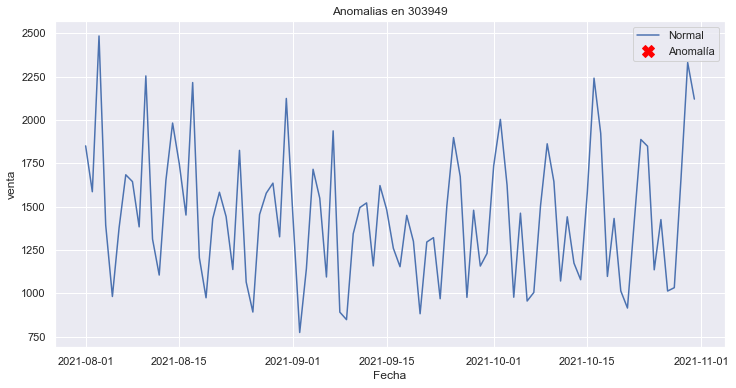

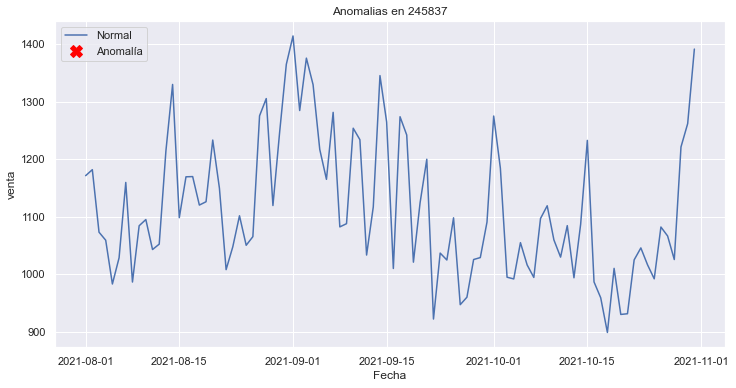

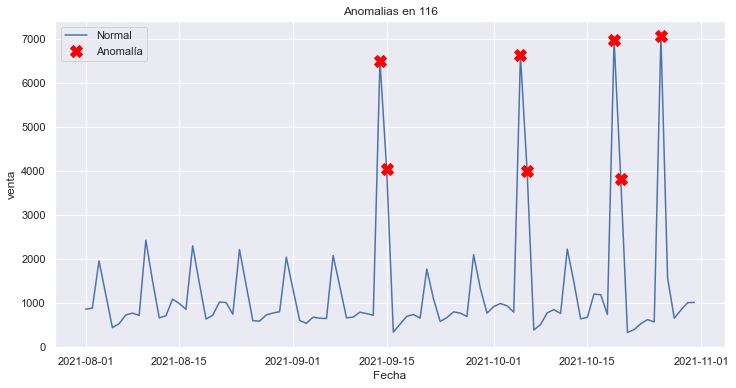

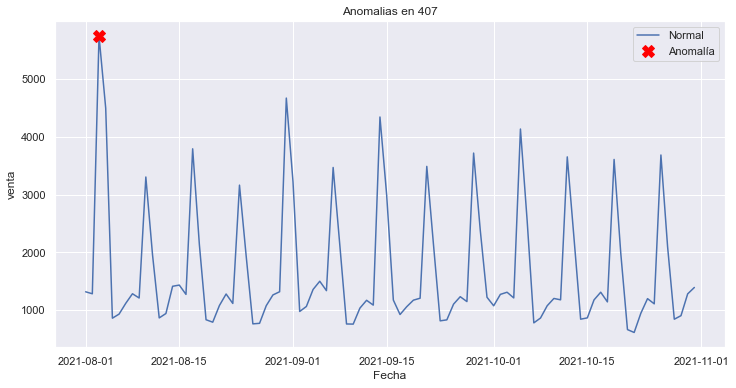

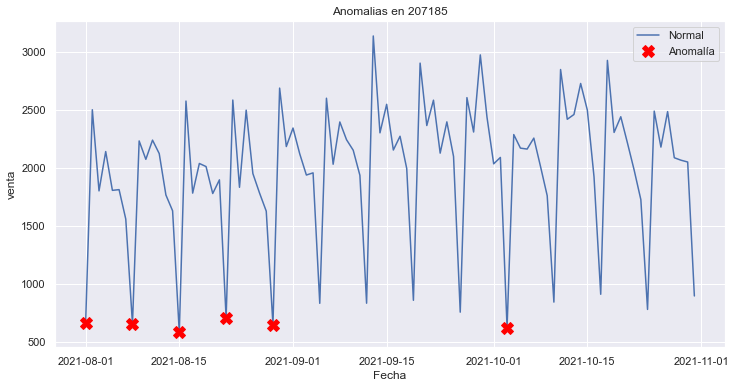

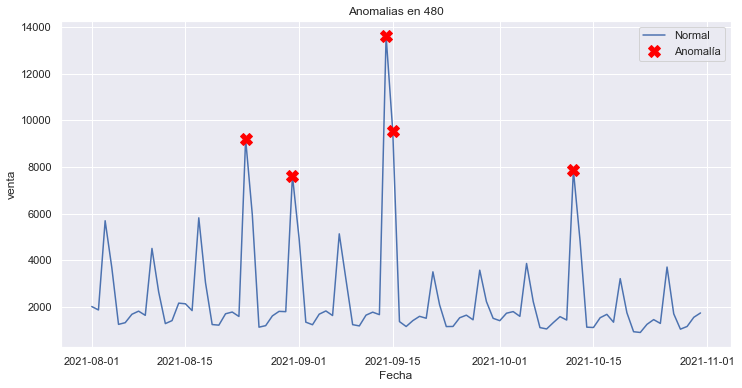

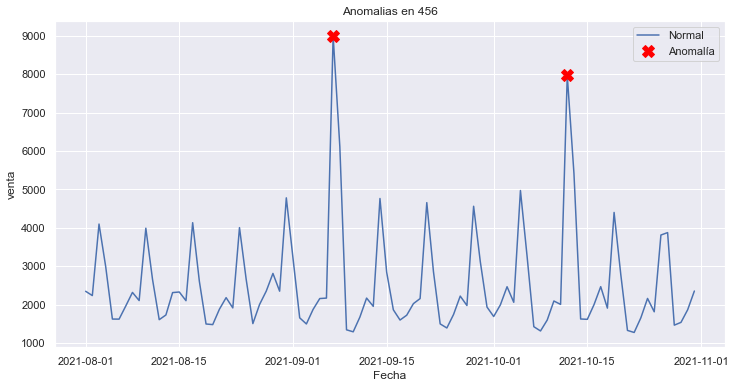

In [52]:
for elemento in nombre_top_producto:
  det_anomalias(venta_por_producto, elemento)

En las figuras anteriores al contrario de la hipótesis del regreso a clases y la Independencia Mexicana, las anomalías están distribuidas a lo largo de toda la serie, por lo que un análisis de que tipo de producto es ayudaría a saber que produce estos eventos.

## Pronóstico

### SARIMAX

In [53]:
sarimax_msle_lista = []
for elemento in nombre_top_producto:
   sarimax_msle_lista.append(train_pred_sarimax(train, test, elemento))


In [54]:
print('MSLE mean: ', sum(sarimax_msle_lista)/len(sarimax_msle_lista))

MSLE mean:  0.06917022483903197


### Transformación de datos


In [55]:
dir_x_y = {}
for elemento in nombre_top_producto:
  dir_x_y[elemento] = transformador(venta_por_producto[elemento])

In [56]:
lista_x_y = []
for elemento in nombre_top_producto:
  lista_x_y.append(escalador(dir_x_y, elemento))

## XGBoost

In [57]:
# XGBoost
xgboost_msle = []
for num in range(0, 6):
  reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
  reg.fit(lista_x_y[num][0], lista_x_y[num][2], verbose=False) 

  yhat = reg.predict(lista_x_y[num][1])
  msle1 = mean_squared_log_error(lista_x_y[num][3], yhat)
  xgboost_msle.append(msle1)

print('MSLE mean: ',sum(xgboost_msle)/len(xgboost_msle))

MSLE mean:  0.09940065586195519


## KNN

In [58]:
knn_lista_msle = []
for num in range(0,6):
  reg = KNeighborsRegressor(n_neighbors=2)
  reg.fit(lista_x_y[num][0], lista_x_y[num][2])
  yhat = reg.predict(lista_x_y[num][1])

  msle2 = mean_squared_log_error(lista_x_y[num][3], yhat)
  knn_lista_msle.append(msle2)

print('MSLE mean: ', sum(knn_lista_msle)/len(knn_lista_msle))

MSLE mean:  0.191515467280128


# Concluciones
Después de realizar el análisis de las diferentes aproximaciones a este data set y habiendo utilizado el Mean Squared Logarithmic Error (MSLE) como métrica para comprobar los niveles de estimación se obtienen las siguientes conclusiones:

*   Se omitió el uso de datos del 2020 por la situación de la pandemia, y que esto llegase a afectar las estimaciones de los modelos, los datos de precio tienen mayor peso en el análisis por producto-tipo de tienda, el cual.
*   Se realizó el entrenamiento y pronostico de los modelos de SARIMAX, XGBRegressor y KNeighborsRegressor y se realizó el pronóstico del lapso del 15 al 31 de Octubre del 2021, utilizando los datos conocidos para sus respectivas validaciones.
*   Para este problema en particular se recomienda utilizar el análisis de ventas promedio por cada tipo de tienda.
*   EL modelo con el mejor MSLE fue el de XGBRegressor, el cual se escogió para realizar la predicción para el lapso del 01 al 15 de Noviembre del 2021.
* Para un mejor análisis de anomalías para el caso de premio promedio por producto-tipo de tienda se recomienda añadir a los datos el tipo de producto y utilizar fechas relevantes (Días festivos, regreso a clases, etc.)



In [83]:
#aux_prod = df_ventas.groupby(['Producto', 'Formato', 'Subformato', 'id_fec_diaria']).mean()
#aux_prod
df_ventas[(df_ventas['Producto']==116) & (df_ventas['Formato']=='Hiper') & (df_ventas['Subformato']=='Basico')]

,Formato,Subformato,Producto,id_fec_diaria,Venta,Precio,Venta_aa,Precio_aa
132078,Hiper,Basico,116,2021-08-01,2335.494020,68.906064,2583.950001,48.858814
132079,Hiper,Basico,116,2021-08-02,1998.185009,68.940889,1719.843992,56.831714
132080,Hiper,Basico,116,2021-08-03,4123.088982,59.041418,4349.557018,52.735090
132081,Hiper,Basico,116,2021-08-04,2610.890009,59.039009,2658.278996,52.832720
132082,Hiper,Basico,116,2021-08-05,1053.632004,68.979350,1790.165016,56.674593
...,...,...,...,...,...,...,...,...
132165,Hiper,Basico,116,2021-10-27,3800.432011,48.958421,3786.162012,36.885926
132166,Hiper,Basico,116,2021-10-28,1623.338992,49.275825,1800.872999,39.076118
132167,Hiper,Basico,116,2021-10-29,1953.113984,49.222514,1917.007998,43.999527
132168,Hiper,Basico,116,2021-10-30,2386.549006,49.139242,2556.072014,43.930651
